In [ ]:
import json
# Used for loading and parsing the training history or saved metrics from JSON files.

import matplotlib.pyplot as plt
# Used for creating and customizing plots to visualize AUC trends and performance comparisons.

import numpy as np
# Used for numerical computations such as arrays, unique labels, and performance metrics.

from sklearn.metrics import roc_auc_score
# Used to calculate the ROC-AUC score (Area Under the Curve) for evaluating classification performance.

from sklearn.preprocessing import label_binarize
# Converts class labels into a one-hot encoded binary format.
# Required when calculating multi-class ROC-AUC scores.

from collections import defaultdict
# A dictionary-like structure used to store and organize data.
# Automatically initializes empty lists/dicts when accessing missing keys.
# Helpful for storing per-round, per-class, and per-client metrics.

import re  # Added import for regular expressions
# Used for extracting numeric values (like class IDs) from string keys,
# especially when parsing class-wise AUC metrics such as 'class_0_auc', 'class_1_auc', etc.


In [ ]:
# --- Configuration ---
# Path to the training history file that stores metrics collected during training.
# This JSON file is expected to be generated by the federated ViT training script.
filename = "training_history.json"

# --- Load the training history from the JSON file ---
try:
    # Attempt to open and read the JSON file containing the training history
    with open(filename, 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    # If the file is not found, display an error and stop execution
    print(f"Error: {filename} not found. Please ensure the file exists and is in the correct directory.")
    exit()
except json.JSONDecodeError:
    # If the JSON structure is invalid or corrupted, display an error and stop execution
    print(f"Error: Invalid JSON in {filename}. The file may be corrupted.")
    exit()

# --- Data Validation and Preprocessing ---
# At this stage, we ensure the loaded data is valid and correctly formatted

# The expected structure for `history` is a list of dictionaries:
# [
#   {
#       "round": 1,
#       "client_histories": [...],
#       "global_test_histories": [...]
#   },
#   {
#       "round": 2,
#       "client_histories": [...],
#       "global_test_histories": [...]
#   },
#   ...
# ]
# Each dictionary stores metrics for a single training round.

# Check if the loaded history is a non-empty list (expected structure)
if not isinstance(history, list) or not history:
    # If the structure is invalid, display an error message
    print("Error: The loaded history is not in the expected list format or is empty.")
    
    # Handle backward compatibility: In older implementations, history might be saved as a single dictionary.
    if isinstance(history, dict):
        # If we detect a single dictionary, convert it into a list for consistency
        print("Warning: Loaded history is a dictionary, converting to a list containing the dictionary.")
        history = [history]
    else:
        # If the data is neither a valid list nor a dictionary, exit the program
        exit()


In [ ]:
# --- Determine NUM_CLIENTS and num_classes from the loaded history ---

# Initialize variables to store:
# 1. NUM_CLIENTS → The total number of clients participating in federated learning.
# 2. num_classes → The total number of classes in the dataset.
# 3. found_valid_data → Flag to track if we successfully extracted valid client/class info.
NUM_CLIENTS = 0
num_classes = 0
found_valid_data = False

# Loop through all rounds of training stored in the history
for round_data in history:
    # Ensure that the round contains valid client-level information
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list) and round_data['client_histories']:
        
        # Get the number of clients from the length of the client_histories list
        NUM_CLIENTS = len(round_data['client_histories'])

        # --- Try to infer num_classes using available data ---
        # Check each client’s data to see where we can determine the number of classes
        for client_h in round_data['client_histories']:

            # CASE 1: Use 'class_aucs' dictionary if available
            # 'class_aucs' usually has keys like: 'class_0_auc', 'class_1_auc', etc.
            if 'class_aucs' in client_h and client_h['class_aucs']:
                max_class_id = -1  # Track the highest class index found

                # Iterate through the class_aucs keys to extract class IDs
                for key in client_h['class_aucs'].keys():
                    match = re.match(r'class_(\d+)_auc', key)  # Regex to extract the class number
                    if match:
                        # Update max_class_id based on the extracted class number
                        max_class_id = max(max_class_id, int(match.group(1)))

                # If at least one valid class ID was found, compute num_classes
                if max_class_id != -1:
                    num_classes = max_class_id + 1  # Add +1 because class IDs are zero-based
                    break  # Found num_classes → stop checking this client's data

            # CASE 2: Use 'all_labels' array if 'class_aucs' is not available
            elif 'all_labels' in client_h and client_h['all_labels']:
                # Extract the unique labels used in this client's dataset
                unique_labels = np.unique(client_h['all_labels'])

                # If labels exist, determine num_classes from the highest label index
                if len(unique_labels) > 0:
                    num_classes = max(unique_labels) + 1  # Add +1 because labels are zero-based
                    break  # Found num_classes → stop checking this client's data

        # If we successfully determined num_classes, set flag and stop further searching
        if num_classes > 0:
            found_valid_data = True
            break  # Exit the outer loop, since we now have the required info

# --- Final Validation ---
# If we couldn't find either the number of clients or number of classes, exit with an error
if not found_valid_data or NUM_CLIENTS == 0:
    print("Error: Could not determine the number of clients or classes from the loaded history.")
    print("Please ensure 'client_histories' and 'class_aucs'/'all_labels' are correctly saved in your JSON.")
    exit()


In [ ]:
# --- Prepare data structures for plotting ---

# We want to store different metrics for visualization later.
# These metrics include:
#   1. Average AUC per client per round
#   2. Global model AUC per client per round
#   3. Class-wise AUC trends of the global model over all rounds

# Dictionary to store the average AUC of each client's LOCAL model per round
# Key   → client_id (e.g., 0, 1, 2, ...)
# Value → List of average AUCs for each round
client_avg_auc_per_round = defaultdict(list)

# Dictionary to store the average AUC of the GLOBAL model tested on each client's dataset
# Key   → client_id (e.g., 0, 1, 2, ...)
# Value → List of global model AUCs for each round
global_avg_auc_per_round = defaultdict(list)

# Dictionary to store CLASS-WISE AUCs of the GLOBAL model (aggregated across all clients)
# Key   → class_id (e.g., 0, 1, 2, ...)
# Value → List of AUCs for each round (averaged across all clients)
class_auc_per_round_global_agg = defaultdict(list)


In [ ]:
# --- Extract AUC data from history ---
for round_idx, round_data in enumerate(history):
    # ==========================
    # 1. PROCESS LOCAL CLIENT AUCs
    # ==========================
    # For each round, we collect the average AUC for every client's local model.
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list):
        for client_id_idx in range(NUM_CLIENTS):
            if client_id_idx < len(round_data['client_histories']):
                client_data = round_data['client_histories'][client_id_idx]
                
                # If class-level AUCs are available for this client, compute average AUC across all classes
                if 'class_aucs' in client_data and client_data['class_aucs']:
                    # Extract AUCs for all classes in order; missing classes get NaN
                    current_client_class_aucs = [
                        client_data['class_aucs'].get(f'class_{i}_auc', np.nan) for i in range(num_classes)
                    ]
                    # Store the mean AUC for this client in this round
                    client_avg_auc_per_round[client_id_idx].append(np.nanmean(current_client_class_aucs))
                else:
                    # If AUCs are missing for this client, append NaN
                    client_avg_auc_per_round[client_id_idx].append(np.nan)
            else:
                # If the client index exceeds available data, append NaN as a placeholder
                client_avg_auc_per_round[client_id_idx].append(np.nan)

    # ==========================
    # 2. PROCESS GLOBAL MODEL AUCs (Aggregated)
    # ==========================
    # For each round, collect ALL labels & predicted probabilities from ALL clients' test sets.
    round_global_all_labels = []
    round_global_all_probs = []

    # Ensure 'global_test_histories' exists and contains valid data
    if 'global_test_histories' in round_data and isinstance(round_data['global_test_histories'], list):
        for global_client_data in round_data['global_test_histories']:
            # Ensure required keys exist before extending lists
            if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
                round_global_all_labels.extend(global_client_data['all_labels'])
                round_global_all_probs.extend(global_client_data['all_probs'])
        
        # ==========================
        # 3. CALCULATE GLOBAL AUCs
        # ==========================
        # If we have at least one label & probability, calculate AUC per class
        if round_global_all_labels and round_global_all_probs:
            true_labels_np = np.array(round_global_all_labels)
            pred_probs_np = np.array(round_global_all_probs)

            # Convert labels to one-hot format for multi-class AUC computation
            binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

            # List to hold AUC for each class in this round
            round_global_class_aucs_list = []

            for i in range(num_classes):
                try:
                    # Only compute AUC if both positive and negative samples exist for this class
                    if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                        auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                        round_global_class_aucs_list.append(auc)
                    else:
                        # If we don't have enough samples for this class, append NaN
                        round_global_class_aucs_list.append(np.nan)
                except ValueError:
                    # Fallback if AUC computation fails for unexpected reasons
                    round_global_class_aucs_list.append(np.nan)
            
            # 3.1. Store the AVERAGE AUC for the global model in this round
            # Using key [0] since it's one global model, not per-client
            global_avg_auc_per_round[0].append(np.nanmean(round_global_class_aucs_list))

            # 3.2. Store CLASS-WISE AUCs for the global model (aggregated across clients)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(round_global_class_aucs_list[i])
        else:
            # If no global data exists for this round, store NaN for global AUCs
            global_avg_auc_per_round[0].append(np.nan)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(np.nan)
    else:
        # If 'global_test_histories' is missing or invalid, append NaN placeholders
        global_avg_auc_per_round[0].append(np.nan)
        for i in range(num_classes):
            class_auc_per_round_global_agg[i].append(np.nan)


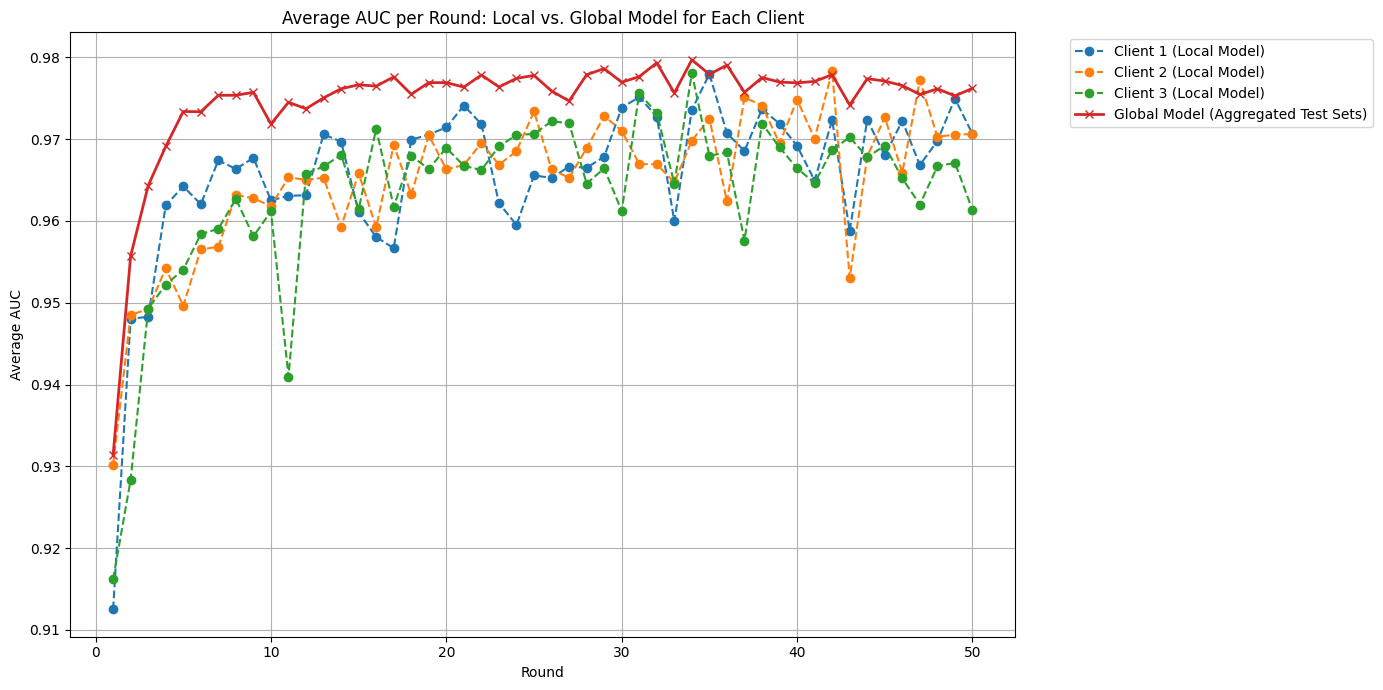

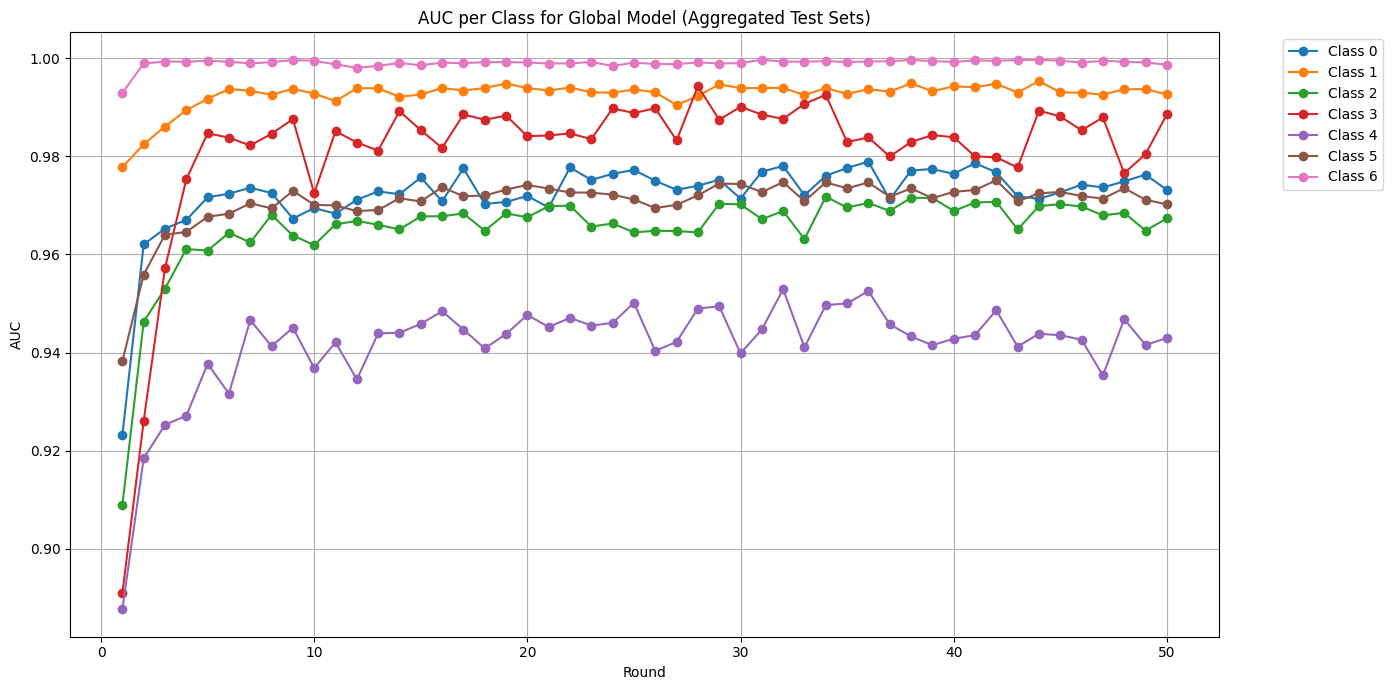

In [ ]:
# --- Plotting Average AUC Comparison for Each Client (Local Model vs. Global Model) ---

# Set figure size for better visibility of plots
plt.figure(figsize=(14, 7))

# Create an x-axis based on the total number of rounds
rounds_axis = range(1, len(history) + 1)

# --- Plot Local Model AUC for Each Client ---
for client_id_idx in range(NUM_CLIENTS):
    # Plot each client's average AUC across all rounds
    plt.plot(
        rounds_axis,
        client_avg_auc_per_round[client_id_idx],  # AUC values for the client's local model
        marker='o',                             # Marker for each round data point
        linestyle='--',                         # Dashed line style for local models
        label=f'Client {client_id_idx + 1} (Local Model)'  # Dynamic legend name for each client
    )

# --- Plot Global Model AUC (Aggregated Across Clients' Test Sets) ---
if global_avg_auc_per_round and global_avg_auc_per_round[0]:
    plt.plot(
        rounds_axis,
        global_avg_auc_per_round[0],            # Average global AUC values
        marker='x',                             # Different marker style for distinction
        linestyle='-',                          # Solid line for the global model
        linewidth=2,                            # Thicker line for emphasis
        label='Global Model (Aggregated Test Sets)'  # Single legend entry for the global model
    )

# Add plot title and labels
plt.title('Average AUC per Round: Local vs. Global Model for Each Client')
plt.xlabel('Round')        # X-axis label
plt.ylabel('Average AUC')  # Y-axis label

# Display the legend outside the main plot for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Enable gridlines for better readability of AUC trends
plt.grid(True)

# Automatically adjust the layout to avoid overlap of labels and legend
plt.tight_layout()

# Show the first plot: Average AUC per Round for Local vs. Global Models
plt.show()


# --- Plotting AUC of Each Class (Global Model, Aggregated Across Clients) ---

# Check if class-wise AUC data is available
if class_auc_per_round_global_agg:
    plt.figure(figsize=(14, 7))  # New figure for class-wise AUCs

    # Loop through each class and plot its AUC values across rounds
    for class_id, auc_values in class_auc_per_round_global_agg.items():
        plt.plot(
            rounds_axis,
            auc_values,          # AUC values for this class
            marker='o',          # Circular marker for class points
            label=f'Class {class_id}'  # Dynamic legend entry for each class
        )

    # Add plot title and labels for clarity
    plt.title('AUC per Class for Global Model (Aggregated Test Sets)')
    plt.xlabel('Round')
    plt.ylabel('AUC')

    # Display class labels outside the main plot area for readability
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add gridlines for clarity
    plt.grid(True)

    # Adjust layout to prevent overlapping text
    plt.tight_layout()

    # Show the second plot: AUC per class over rounds
    plt.show()
else:
    # If no class-level AUC data is available, notify the user
    print("No data available to plot AUC per class for the global model.")


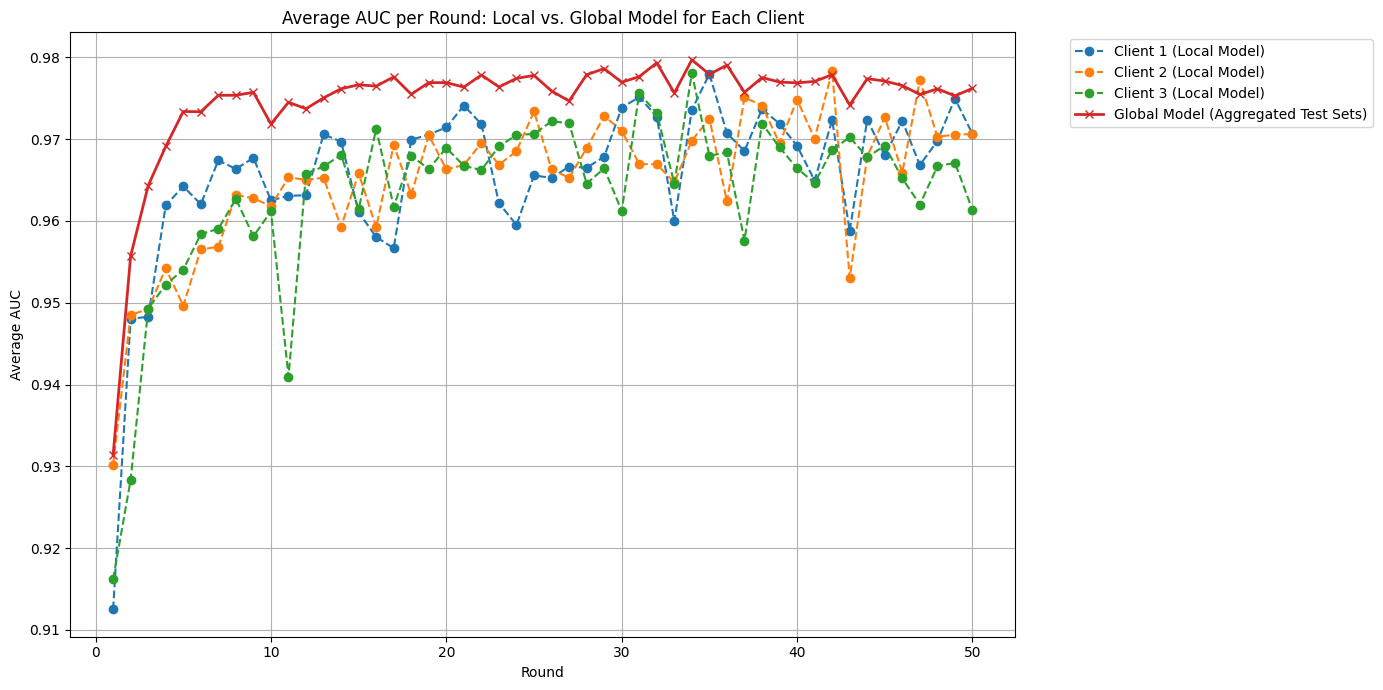

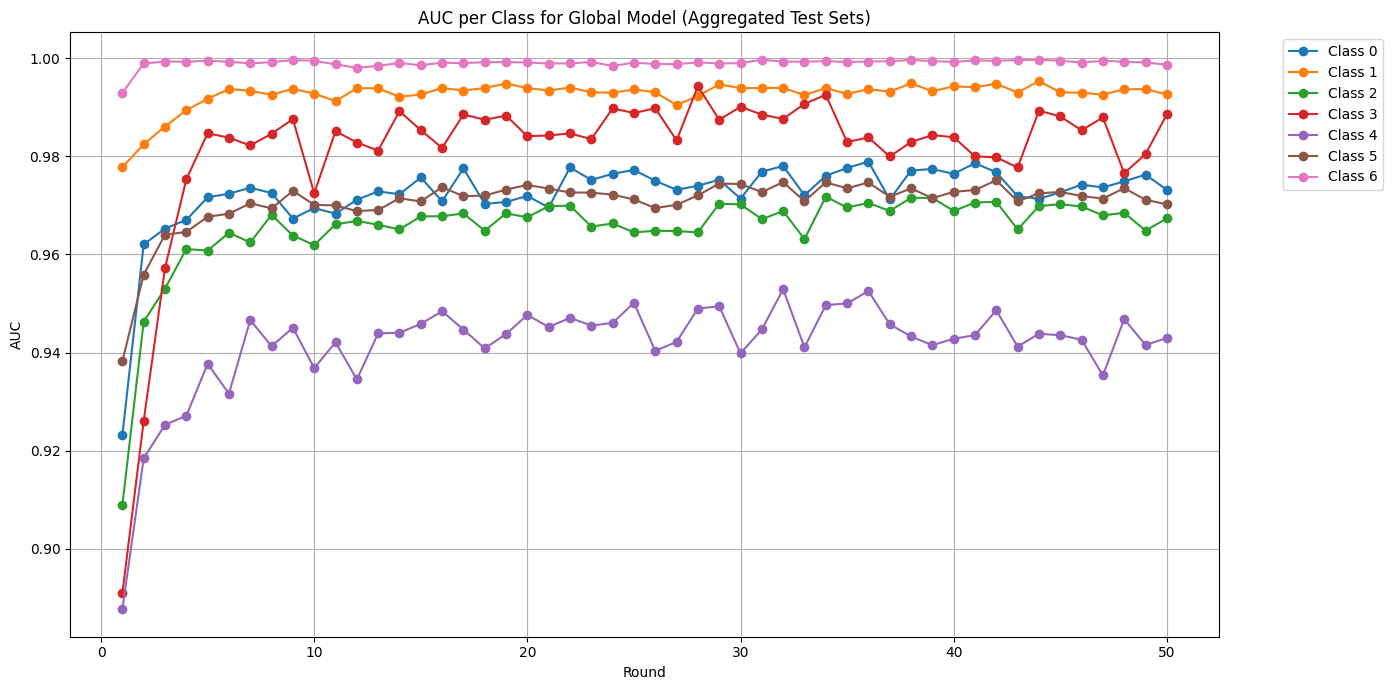

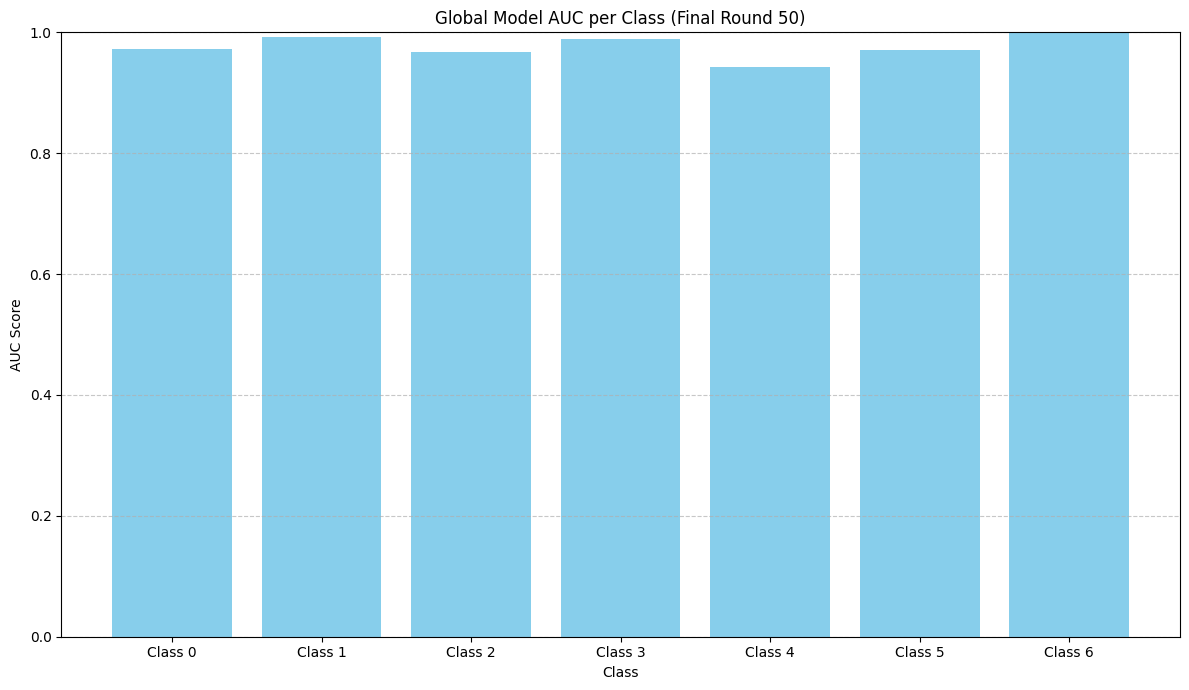

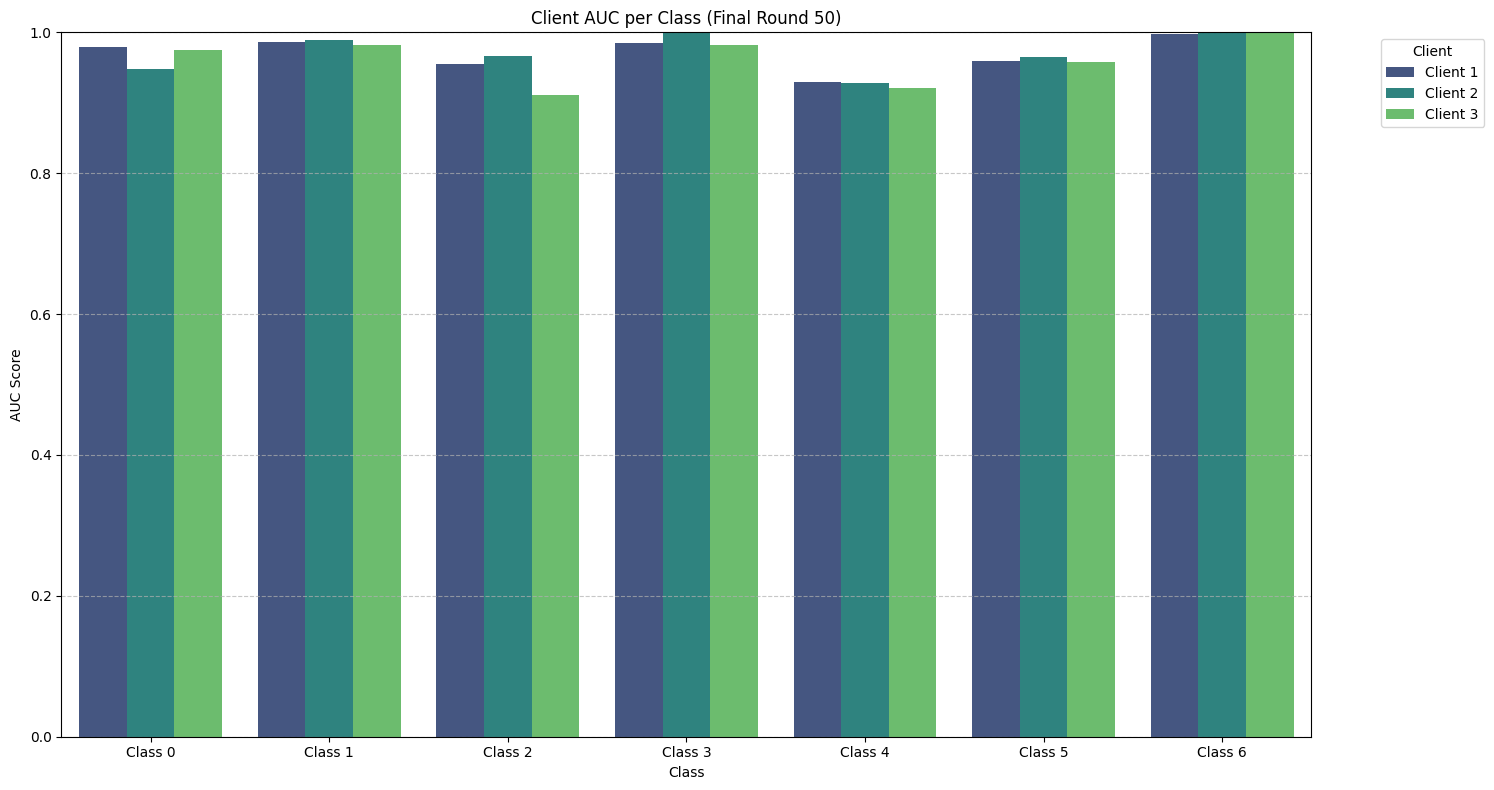

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from collections import defaultdict
import re # Added import for regular expressions
import pandas as pd
import seaborn as sns

# --- Configuration ---
# Assuming you have a training_history.json file generated by your updated training script
filename = "training_history.json"

# --- Load the training history from the JSON file ---
try:
    with open(filename, 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    print(f"Error: {filename} not found. Please ensure the file exists and is in the correct directory.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Invalid JSON in {filename}. The file may be corrupted.")
    exit()

# --- Data Validation and Preprocessing ---
# Ensure history is a list and not empty
if not isinstance(history, list) or not history:
    print("Error: The loaded history is not in the expected list format or is empty.")
    if isinstance(history, dict): # Attempt to correct if it's a single dict (from older saving)
        print("Warning: Loaded history is a dictionary, converting to a list containing the dictionary.")
        history = [history]
    else:
        exit()

# Determine NUM_CLIENTS and num_classes from the loaded history
NUM_CLIENTS = 0
num_classes = 0
found_valid_data = False

for round_data in history:
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list) and round_data['client_histories']:
        NUM_CLIENTS = len(round_data['client_histories'])
        # Try to infer num_classes from 'class_aucs' or 'all_labels'
        for client_h in round_data['client_histories']:
            if 'class_aucs' in client_h and client_h['class_aucs']:
                # Assuming class_aucs keys are like 'class_0_auc', 'class_1_auc', etc.
                max_class_id = -1
                for key in client_h['class_aucs'].keys():
                    match = re.match(r'class_(\d+)_auc', key)
                    if match:
                        max_class_id = max(max_class_id, int(match.group(1)))
                if max_class_id != -1:
                    num_classes = max_class_id + 1
                    break # Found num_classes, exit inner loop
            elif 'all_labels' in client_h and client_h['all_labels']:
                unique_labels = np.unique(client_h['all_labels'])
                if len(unique_labels) > 0:
                    num_classes = max(unique_labels) + 1
                    break # Found num_classes, exit inner loop
        if num_classes > 0:
            found_valid_data = True
            break # Found client data and num_classes, exit outer loop

if not found_valid_data or NUM_CLIENTS == 0:
    print("Error: Could not determine the number of clients or classes from the loaded history.")
    print("Please ensure 'client_histories' and 'class_aucs'/'all_labels' are correctly saved in your JSON.")
    exit()

# --- Prepare data structures for plotting ---
# For AUC comparison of each client (local model vs. global model)
client_avg_auc_per_round = defaultdict(list)  # Average AUC for each client's local model
global_avg_auc_per_round = defaultdict(list)  # Average AUC for global model on each client's test set

# For AUC of each class (global model, aggregated across clients)
class_auc_per_round_global_agg = defaultdict(list)

# --- Extract AUC data from history ---
for round_idx, round_data in enumerate(history):
    # Process client AUCs (Local Models)
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list):
        for client_id_idx in range(NUM_CLIENTS):
            if client_id_idx < len(round_data['client_histories']):
                client_data = round_data['client_histories'][client_id_idx]
                if 'class_aucs' in client_data and client_data['class_aucs']:
                    # Collect all class AUCs for this client in this round
                    current_client_class_aucs = [client_data['class_aucs'].get(f'class_{i}_auc', np.nan) for i in range(num_classes)]
                    client_avg_auc_per_round[client_id_idx].append(np.nanmean(current_client_class_aucs))
                else:
                    client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if class_aucs is missing
            else:
                client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if client data is missing

    # Process global model AUCs (on each client's test set)
    # We will collect all true_labels and all_probs from all clients' global_test_histories for this round
    round_global_all_labels = []
    round_global_all_probs = []
    
    if 'global_test_histories' in round_data and isinstance(round_data['global_test_histories'], list):
        for global_client_data in round_data['global_test_histories']:
            if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
                round_global_all_labels.extend(global_client_data['all_labels'])
                round_global_all_probs.extend(global_client_data['all_probs'])
        
        # Calculate overall global AUC for this round (aggregated across all clients' test sets)
        if round_global_all_labels and round_global_all_probs:
            true_labels_np = np.array(round_global_all_labels)
            pred_probs_np = np.array(round_global_all_probs)

            # Binarize true labels for multi-class AUC
            binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

            round_global_class_aucs_list = []
            for i in range(num_classes):
                try:
                    # Check if both positive and negative samples exist for the class
                    if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                        auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                        round_global_class_aucs_list.append(auc)
                    else:
                        round_global_class_aucs_list.append(np.nan)
                except ValueError:
                    round_global_class_aucs_list.append(np.nan)
            
            # Store the average AUC for the global model in this round
            # We use index 0 for global_avg_auc_per_round as it's a single global average
            global_avg_auc_per_round[0].append(np.nanmean(round_global_class_aucs_list))

            # Store AUC per class for the global model (aggregated)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(round_global_class_aucs_list[i])
        else: # If no data for global model in this round
            global_avg_auc_per_round[0].append(np.nan)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(np.nan)
    else: # If 'global_test_histories' key is missing or not a list
        global_avg_auc_per_round[0].append(np.nan)
        for i in range(num_classes):
            class_auc_per_round_global_agg[i].append(np.nan)


# --- Plotting Average AUC Comparison for Each Client (Local Model vs. Global Model) ---
plt.figure(figsize=(14, 7))
rounds_axis = range(1, len(history) + 1)

for client_id_idx in range(NUM_CLIENTS):
    # Plot local model AUC
    plt.plot(rounds_axis, client_avg_auc_per_round[client_id_idx],
             marker='o', linestyle='--', label=f'Client {client_id_idx + 1} (Local Model)')

# Plot global model AUC (only one line for the aggregated global model)
if global_avg_auc_per_round and global_avg_auc_per_round[0]:
    plt.plot(rounds_axis, global_avg_auc_per_round[0],
             marker='x', linestyle='-', linewidth=2, label='Global Model (Aggregated Test Sets)')

plt.title('Average AUC per Round: Local vs. Global Model for Each Client')
plt.xlabel('Round')
plt.ylabel('Average AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting AUC of Each Class (Global Model, aggregated across clients) ---
if class_auc_per_round_global_agg:
    plt.figure(figsize=(14, 7))
    for class_id, auc_values in class_auc_per_round_global_agg.items():
        plt.plot(rounds_axis, auc_values, marker='o', label=f'Class {class_id}')
    plt.title('AUC per Class for Global Model (Aggregated Test Sets)')
    plt.xlabel('Round')
    plt.ylabel('AUC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot AUC per class for the global model.")

# --- NEW PLOTS: Bar Graphs for Final Round AUCs ---

# 1. AUC against the class for the final round of the global model
if history and 'global_test_histories' in history[-1] and history[-1]['global_test_histories']:
    final_round_global_aucs = {}
    # Aggregate class AUCs from all clients' global test histories in the final round
    final_global_all_labels = []
    final_global_all_probs = []
    for global_client_data in history[-1]['global_test_histories']:
        if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
            final_global_all_labels.extend(global_client_data['all_labels'])
            final_global_all_probs.extend(global_client_data['all_probs'])

    if final_global_all_labels and final_global_all_probs:
        true_labels_np = np.array(final_global_all_labels)
        pred_probs_np = np.array(final_global_all_probs)
        binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

        for i in range(num_classes):
            try:
                if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                    auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                    final_round_global_aucs[f'Class {i}'] = auc
                else:
                    final_round_global_aucs[f'Class {i}'] = np.nan
            except ValueError:
                final_round_global_aucs[f'Class {i}'] = np.nan
    
    if final_round_global_aucs:
        class_labels = list(final_round_global_aucs.keys())
        auc_values = list(final_round_global_aucs.values())
        
        plt.figure(figsize=(12, 7))
        plt.bar(class_labels, auc_values, color='skyblue')
        plt.title(f'Global Model AUC per Class (Final Round {len(history)})')
        plt.xlabel('Class')
        plt.ylabel('AUC Score')
        plt.ylim(0, 1) # AUC scores are between 0 and 1
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Global Model per Class in the final round.")
else:
    print("No global test history found for the final round to plot AUC per class.")


# 2. AUC of each client for each class (for the final round)
if history and 'client_histories' in history[-1] and history[-1]['client_histories']:
    final_round_client_data = history[-1]['client_histories']
    
    # Prepare data for grouped bar chart
    client_class_aucs = defaultdict(list)
    client_ids = []
    
    for client_id_idx in range(NUM_CLIENTS):
        if client_id_idx < len(final_round_client_data):
            client_h = final_round_client_data[client_id_idx]
            client_ids.append(f'Client {client_h["client_id"]}')
            if 'class_aucs' in client_h and client_h['class_aucs']:
                for i in range(num_classes):
                    auc_val = client_h['class_aucs'].get(f'class_{i}_auc', np.nan)
                    client_class_aucs[i].append(auc_val)
            else:
                for i in range(num_classes):
                    client_class_aucs[i].append(np.nan) # Append NaN if class_aucs is missing

    if client_class_aucs:
        # Create a DataFrame for easier plotting with Seaborn (optional, but good for grouped bars)
        # If you strictly want only matplotlib, the logic would be more manual for bar positions
        
        # Convert defaultdict to a list of dictionaries for DataFrame creation
        plot_data = []
        for class_id, auc_values in client_class_aucs.items():
            for client_idx, auc in enumerate(auc_values):
                plot_data.append({'Client': client_ids[client_idx], 'Class': f'Class {class_id}', 'AUC': auc})
        
        df_client_aucs = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(15, 8))
        # Use Seaborn for grouped bar plot, as it handles grouping automatically
        sns.barplot(data=df_client_aucs, x='Class', y='AUC', hue='Client', palette='viridis')
        
        plt.title(f'Client AUC per Class (Final Round {len(history)})')
        plt.xlabel('Class')
        plt.ylabel('AUC Score')
        plt.ylim(0, 1)
        plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Clients per Class in the final round.")
else:
    print("No client history found for the final round to plot AUC per class.")


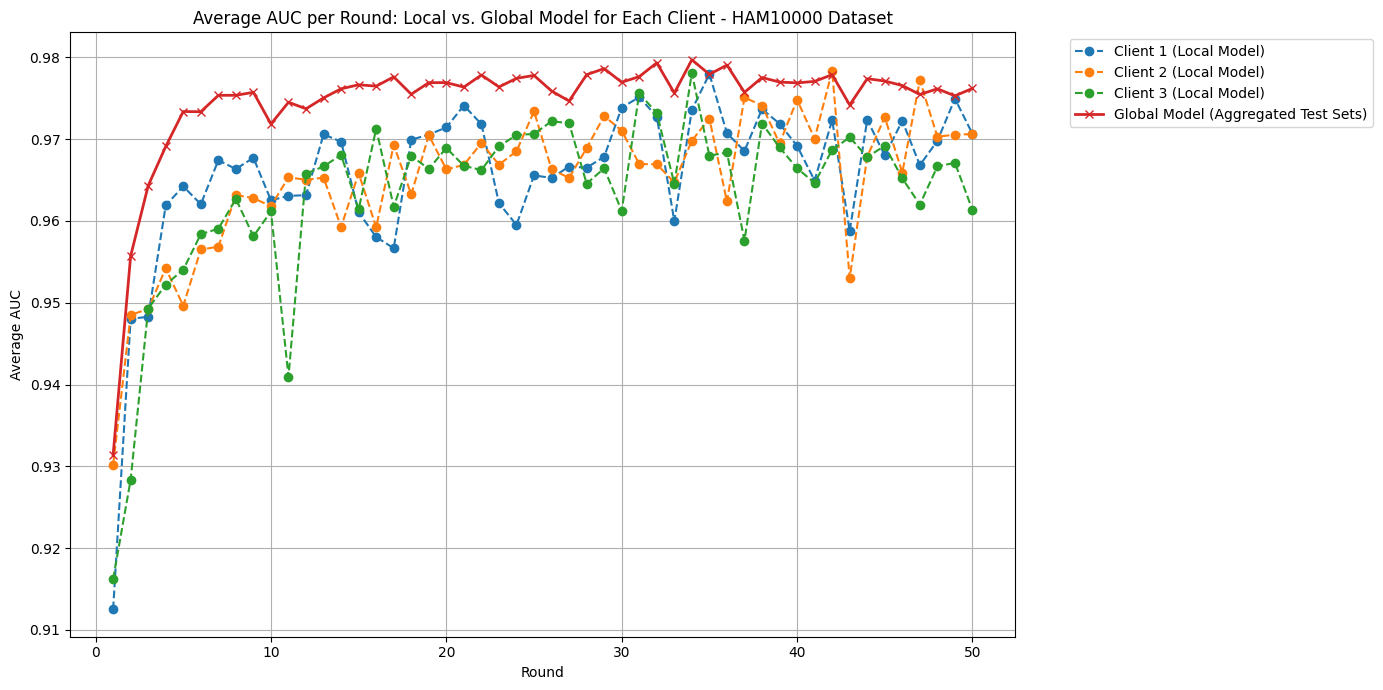

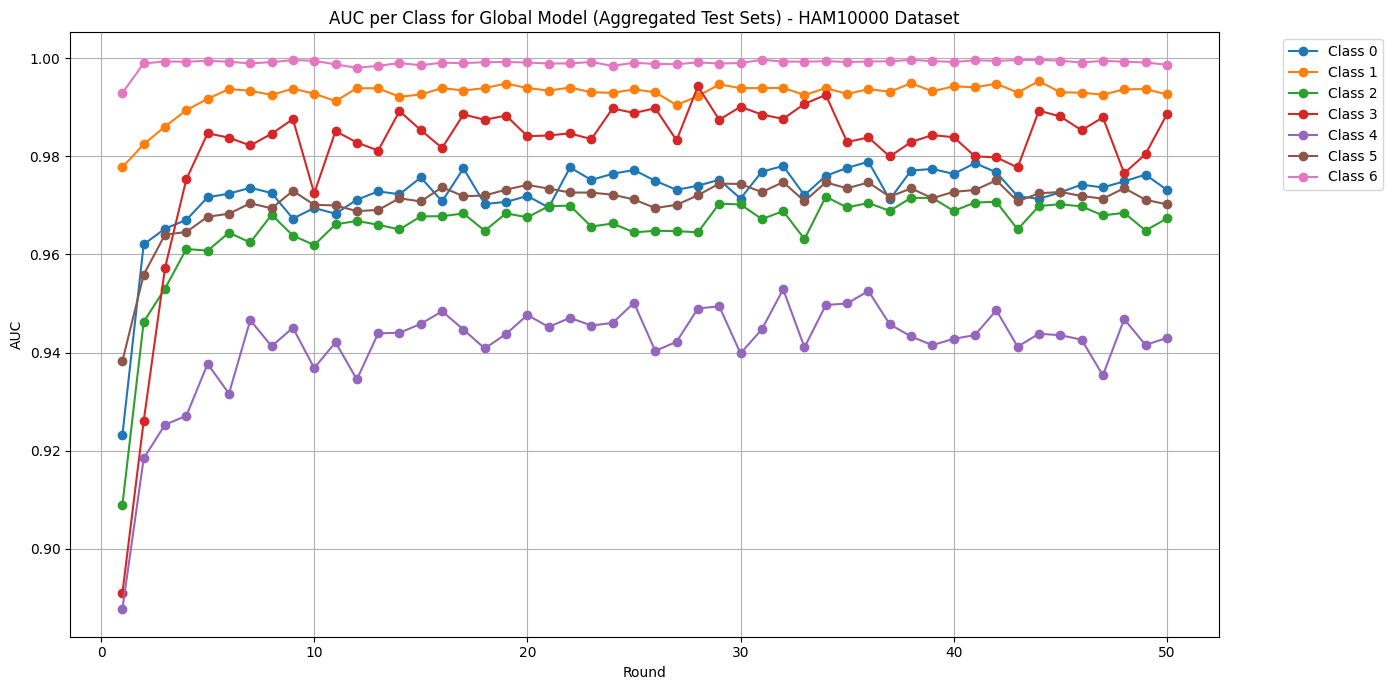

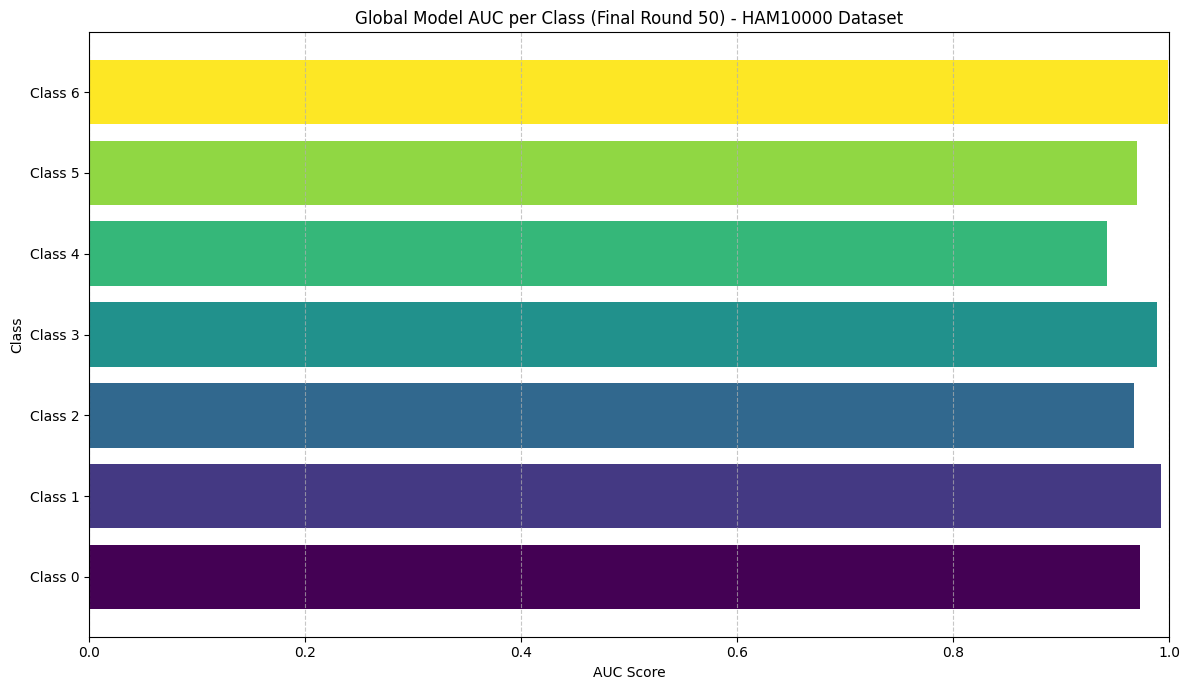

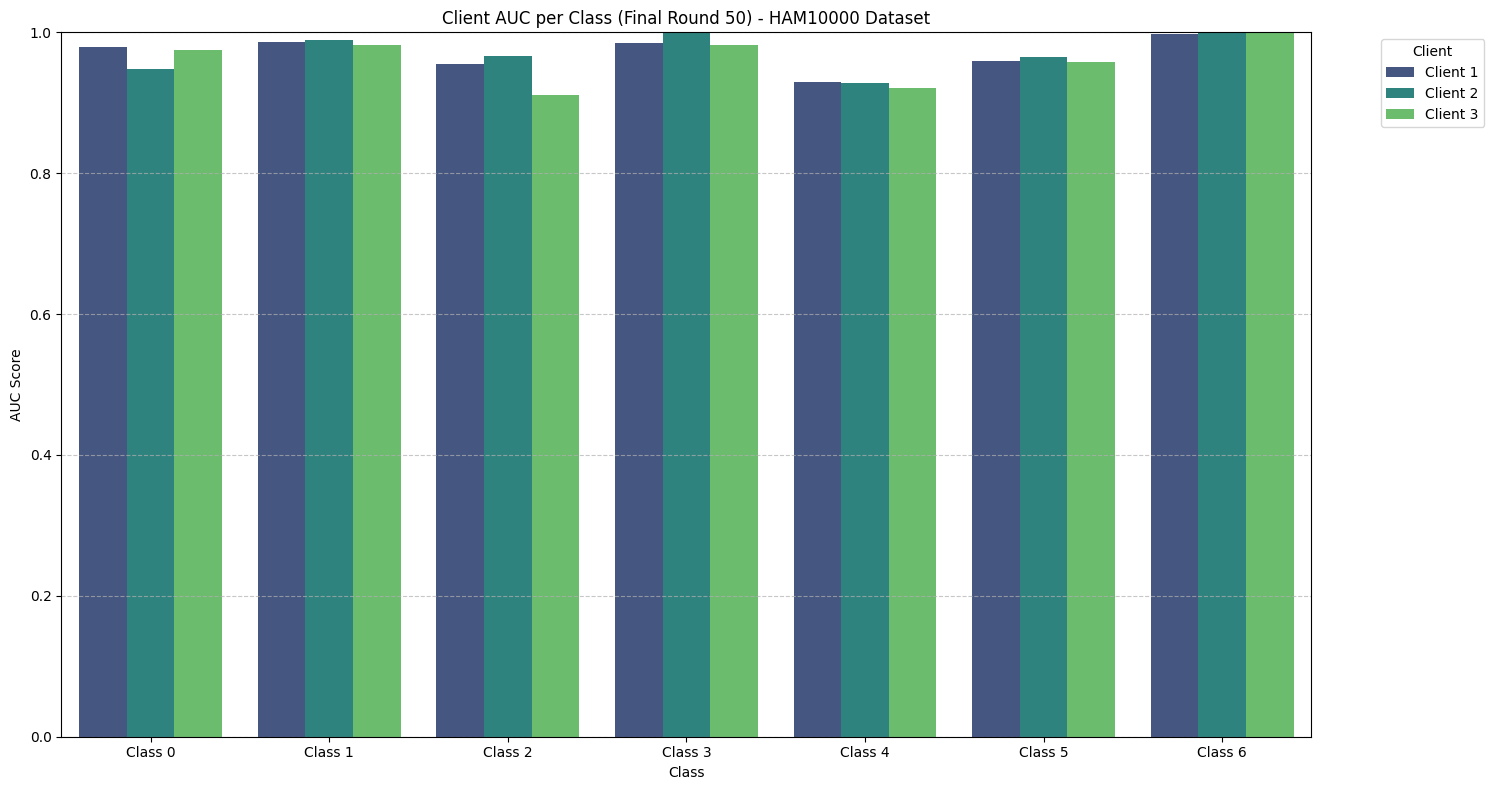

In [13]:
# --- Configuration ---
# Assuming you have a training_history.json file generated by your updated training script
filename = "training_history.json"

# --- Load the training history from the JSON file ---
try:
    with open(filename, 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    print(f"Error: {filename} not found. Please ensure the file exists and is in the correct directory.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Invalid JSON in {filename}. The file may be corrupted.")
    exit()

# --- Data Validation and Preprocessing ---
# Ensure history is a list and not empty
if not isinstance(history, list) or not history:
    print("Error: The loaded history is not in the expected list format or is empty.")
    if isinstance(history, dict): # Attempt to correct if it's a single dict (from older saving)
        print("Warning: Loaded history is a dictionary, converting to a list containing the dictionary.")
        history = [history]
    else:
        exit()

# Determine NUM_CLIENTS and num_classes from the loaded history
NUM_CLIENTS = 0
num_classes = 0
found_valid_data = False

for round_data in history:
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list) and round_data['client_histories']:
        NUM_CLIENTS = len(round_data['client_histories'])
        # Try to infer num_classes from 'class_aucs' or 'all_labels'
        for client_h in round_data['client_histories']:
            if 'class_aucs' in client_h and client_h['class_aucs']:
                # Assuming class_aucs keys are like 'class_0_auc', 'class_1_auc', etc.
                max_class_id = -1
                for key in client_h['class_aucs'].keys():
                    match = re.match(r'class_(\d+)_auc', key)
                    if match:
                        max_class_id = max(max_class_id, int(match.group(1)))
                if max_class_id != -1:
                    num_classes = max_class_id + 1
                    break # Found num_classes, exit inner loop
            elif 'all_labels' in client_h and client_h['all_labels']:
                unique_labels = np.unique(client_h['all_labels'])
                if len(unique_labels) > 0:
                    num_classes = max(unique_labels) + 1
                    break # Found num_classes, exit inner loop
        if num_classes > 0:
            found_valid_data = True
            break # Found client data and num_classes, exit outer loop

if not found_valid_data or NUM_CLIENTS == 0:
    print("Error: Could not determine the number of clients or classes from the loaded history.")
    print("Please ensure 'client_histories' and 'class_aucs'/'all_labels' are correctly saved in your JSON.")
    exit()

# --- Prepare data structures for plotting ---
# For AUC comparison of each client (local model vs. global model)
client_avg_auc_per_round = defaultdict(list)  # Average AUC for each client's local model
global_avg_auc_per_round = defaultdict(list)  # Average AUC for global model on each client's test set

# For AUC of each class (global model, aggregated across clients)
class_auc_per_round_global_agg = defaultdict(list)

# --- Extract AUC data from history ---
for round_idx, round_data in enumerate(history):
    # Process client AUCs (Local Models)
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list):
        for client_id_idx in range(NUM_CLIENTS):
            if client_id_idx < len(round_data['client_histories']):
                client_data = round_data['client_histories'][client_id_idx]
                if 'class_aucs' in client_data and client_data['class_aucs']:
                    # Collect all class AUCs for this client in this round
                    current_client_class_aucs = [client_data['class_aucs'].get(f'class_{i}_auc', np.nan) for i in range(num_classes)]
                    client_avg_auc_per_round[client_id_idx].append(np.nanmean(current_client_class_aucs))
                else:
                    client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if class_aucs is missing
            else:
                client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if client data is missing

    # Process global model AUCs (on each client's test set)
    # We will collect all true_labels and all_probs from all clients' global_test_histories for this round
    round_global_all_labels = []
    round_global_all_probs = []
    
    if 'global_test_histories' in round_data and isinstance(round_data['global_test_histories'], list):
        for global_client_data in round_data['global_test_histories']:
            if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
                round_global_all_labels.extend(global_client_data['all_labels'])
                round_global_all_probs.extend(global_client_data['all_probs'])
        
        # Calculate overall global AUC for this round (aggregated across all clients' test sets)
        if round_global_all_labels and round_global_all_probs:
            true_labels_np = np.array(round_global_all_labels)
            pred_probs_np = np.array(round_global_all_probs)

            # Binarize true labels for multi-class AUC
            binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

            round_global_class_aucs_list = []
            for i in range(num_classes):
                try:
                    # Check if both positive and negative samples exist for the class
                    if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                        auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                        round_global_class_aucs_list.append(auc)
                    else:
                        round_global_class_aucs_list.append(np.nan)
                except ValueError:
                    round_global_class_aucs_list.append(np.nan)
            
            # Store the average AUC for the global model in this round
            # We use index 0 for global_avg_auc_per_round as it's a single global average
            global_avg_auc_per_round[0].append(np.nanmean(round_global_class_aucs_list))

            # Store AUC per class for the global model (aggregated)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(round_global_class_aucs_list[i])
        else: # If no data for global model in this round
            global_avg_auc_per_round[0].append(np.nan)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(np.nan)
    else: # If 'global_test_histories' key is missing or not a list
        global_avg_auc_per_round[0].append(np.nan)
        for i in range(num_classes):
            class_auc_per_round_global_agg[i].append(np.nan)


# --- Plotting Average AUC Comparison for Each Client (Local Model vs. Global Model) ---
plt.figure(figsize=(14, 7))
rounds_axis = range(1, len(history) + 1)

for client_id_idx in range(NUM_CLIENTS):
    # Plot local model AUC
    plt.plot(rounds_axis, client_avg_auc_per_round[client_id_idx],
             marker='o', linestyle='--', label=f'Client {client_id_idx + 1} (Local Model)')

# Plot global model AUC (only one line for the aggregated global model)
if global_avg_auc_per_round and global_avg_auc_per_round[0]:
    plt.plot(rounds_axis, global_avg_auc_per_round[0],
             marker='x', linestyle='-', linewidth=2, label='Global Model (Aggregated Test Sets)')

plt.title('Average AUC per Round: Local vs. Global Model for Each Client - HAM10000 Dataset')
plt.xlabel('Round')
plt.ylabel('Average AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting AUC of Each Class (Global Model, aggregated across clients) ---
if class_auc_per_round_global_agg:
    plt.figure(figsize=(14, 7))
    for class_id, auc_values in class_auc_per_round_global_agg.items():
        plt.plot(rounds_axis, auc_values, marker='o', label=f'Class {class_id}')
    plt.title('AUC per Class for Global Model (Aggregated Test Sets) - HAM10000 Dataset')
    plt.xlabel('Round')
    plt.ylabel('AUC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot AUC per class for the global model.")

# --- NEW PLOTS: Bar Graphs for Final Round AUCs ---

# 1. AUC against the class for the final round of the global model (inverted axes, different colors)
if history and 'global_test_histories' in history[-1] and history[-1]['global_test_histories']:
    final_round_global_aucs = {}
    # Aggregate class AUCs from all clients' global test histories in the final round
    final_global_all_labels = []
    final_global_all_probs = []
    for global_client_data in history[-1]['global_test_histories']:
        if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
            final_global_all_labels.extend(global_client_data['all_labels'])
            final_global_all_probs.extend(global_client_data['all_probs'])

    if final_global_all_labels and final_global_all_probs:
        true_labels_np = np.array(final_global_all_labels)
        pred_probs_np = np.array(final_global_all_probs)
        binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

        for i in range(num_classes):
            try:
                if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                    auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                    final_round_global_aucs[f'Class {i}'] = auc
                else:
                    final_round_global_aucs[f'Class {i}'] = np.nan
            except ValueError:
                final_round_global_aucs[f'Class {i}'] = np.nan
    
    if final_round_global_aucs:
        class_labels = list(final_round_global_aucs.keys())
        auc_values = list(final_round_global_aucs.values())
        
        # Generate a list of colors, one for each bar
        colors = plt.cm.viridis(np.linspace(0, 1, len(class_labels))) # Using 'viridis' colormap

        plt.figure(figsize=(12, 7))
        plt.barh(class_labels, auc_values, color=colors) # Use barh for horizontal bars
        plt.title(f'Global Model AUC per Class (Final Round {len(history)}) - HAM10000 Dataset')
        plt.xlabel('AUC Score') # X-axis is now AUC
        plt.ylabel('Class')     # Y-axis is now Class
        plt.xlim(0, 1) # AUC scores are between 0 and 1
        plt.grid(axis='x', linestyle='--', alpha=0.7) # Grid on x-axis
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Global Model per Class in the final round.")
else:
    print("No global test history found for the final round to plot AUC per class.")


# 2. AUC of each client for each class (for the final round)
if history and 'client_histories' in history[-1] and history[-1]['client_histories']:
    final_round_client_data = history[-1]['client_histories']
    
    # Prepare data for grouped bar chart
    client_class_aucs = defaultdict(list)
    client_ids = []
    
    for client_id_idx in range(NUM_CLIENTS):
        if client_id_idx < len(final_round_client_data):
            client_h = final_round_client_data[client_id_idx]
            client_ids.append(f'Client {client_h["client_id"]}')
            if 'class_aucs' in client_h and client_h['class_aucs']:
                for i in range(num_classes):
                    auc_val = client_h['class_aucs'].get(f'class_{i}_auc', np.nan)
                    client_class_aucs[i].append(auc_val)
            else:
                for i in range(num_classes):
                    client_class_aucs[i].append(np.nan) # Append NaN if class_aucs is missing

    if client_class_aucs:
        # Create a DataFrame for easier plotting with Seaborn (optional, but good for grouped bars)
        # If you strictly want only matplotlib, the logic would be more manual for bar positions
        
        # Convert defaultdict to a list of dictionaries for DataFrame creation
        plot_data = []
        for class_id, auc_values in client_class_aucs.items():
            for client_idx, auc in enumerate(auc_values):
                plot_data.append({'Client': client_ids[client_idx], 'Class': f'Class {class_id}', 'AUC': auc})
        
        df_client_aucs = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(15, 8))
        # Use Seaborn for grouped bar plot, as it handles grouping automatically
        sns.barplot(data=df_client_aucs, x='Class', y='AUC', hue='Client', palette='viridis')
        
        plt.title(f'Client AUC per Class (Final Round {len(history)}) - HAM10000 Dataset')
        plt.xlabel('Class')
        plt.ylabel('AUC Score')
        plt.ylim(0, 1)
        plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Clients per Class in the final round.")
else:
    print("No client history found for the final round to plot AUC per class.")


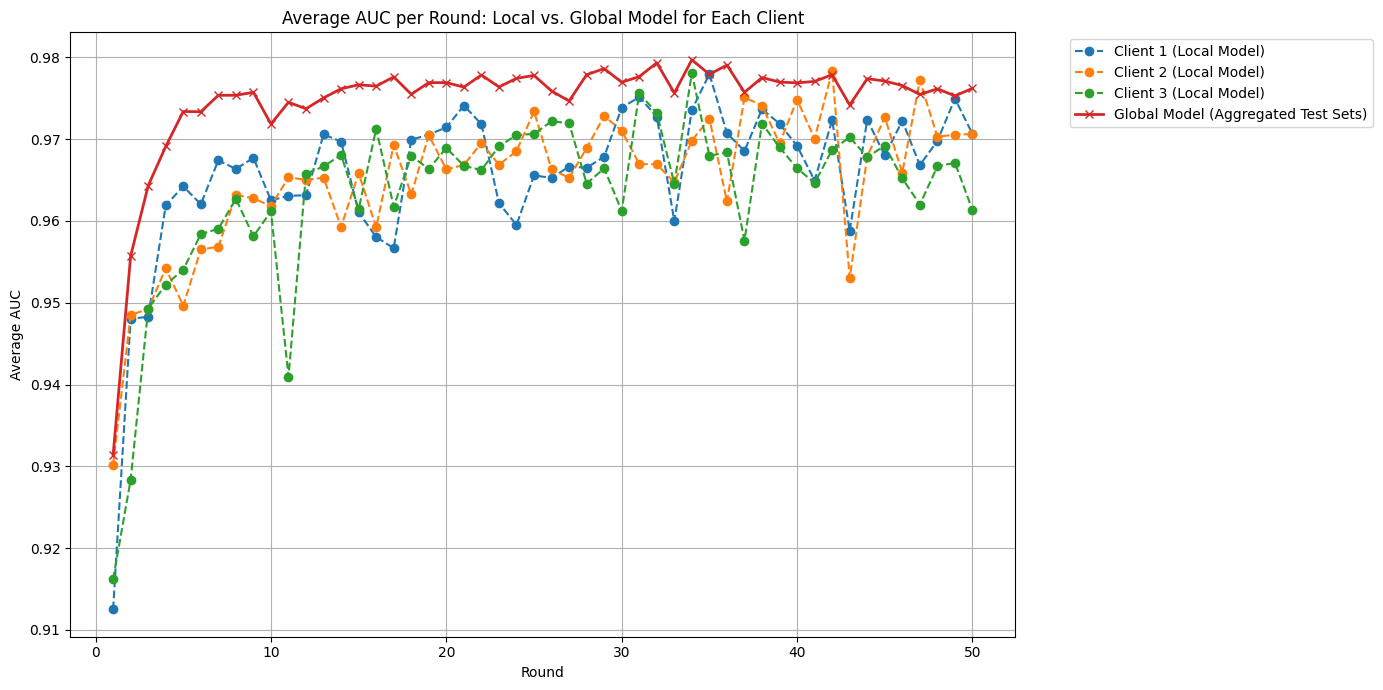

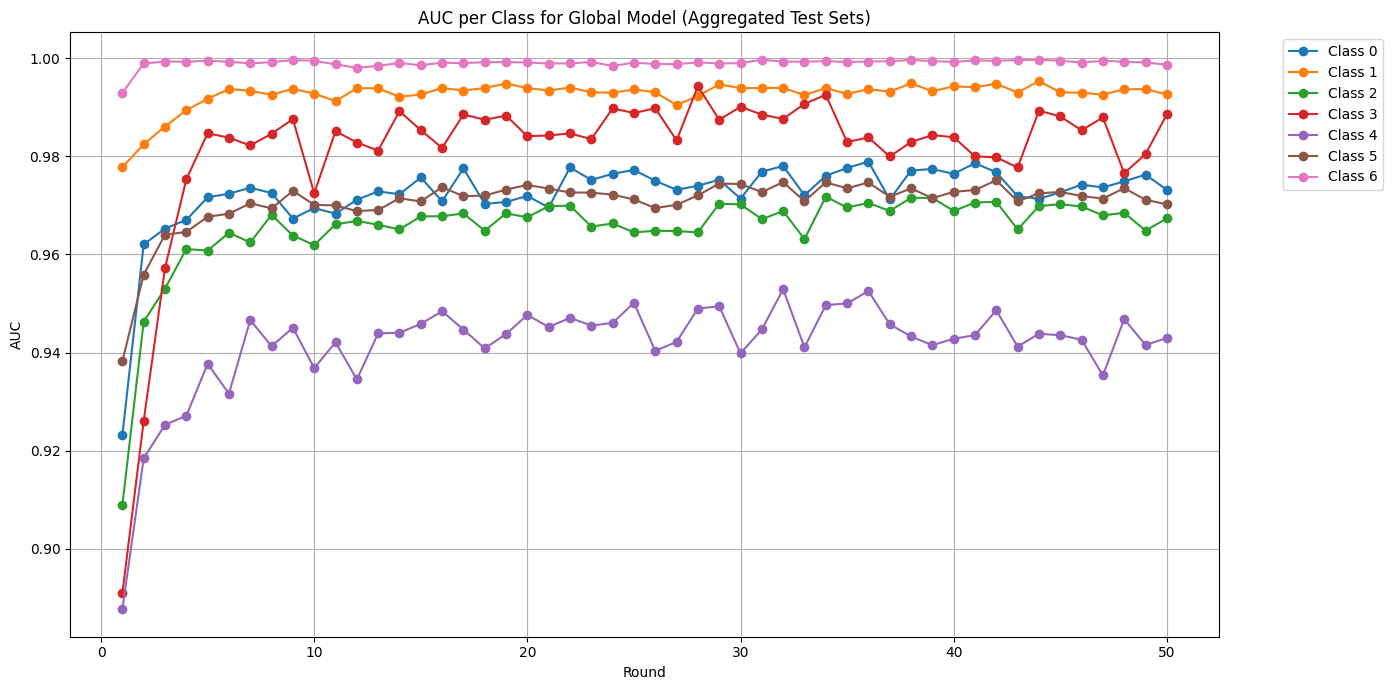

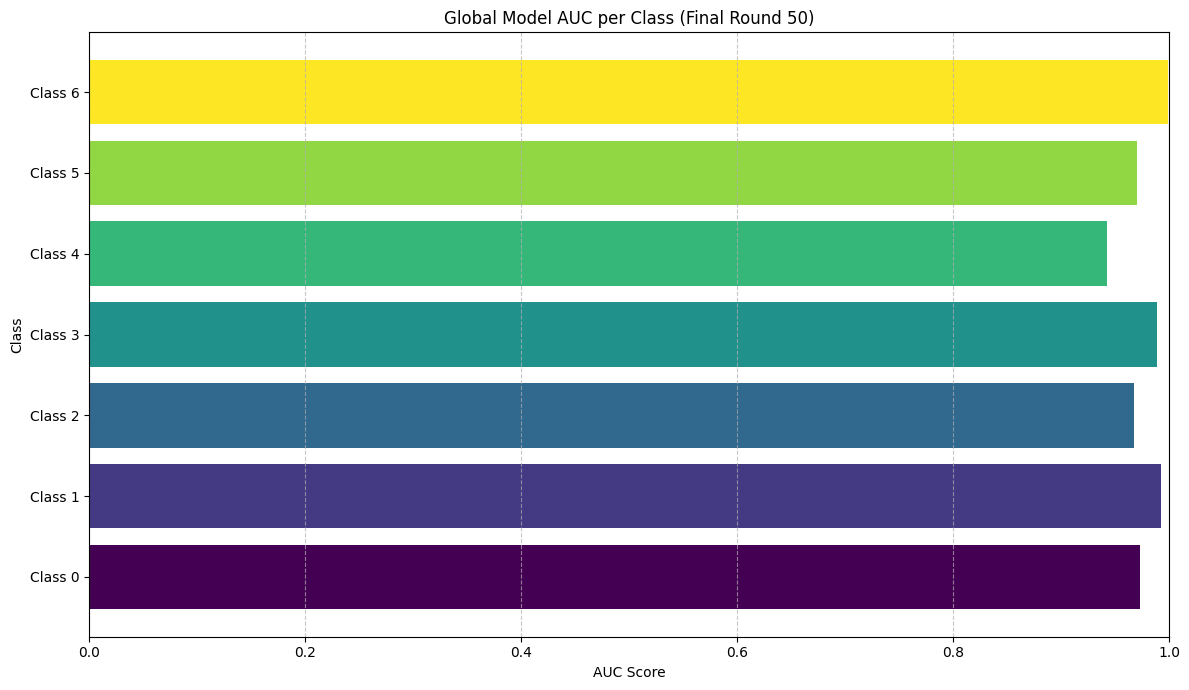

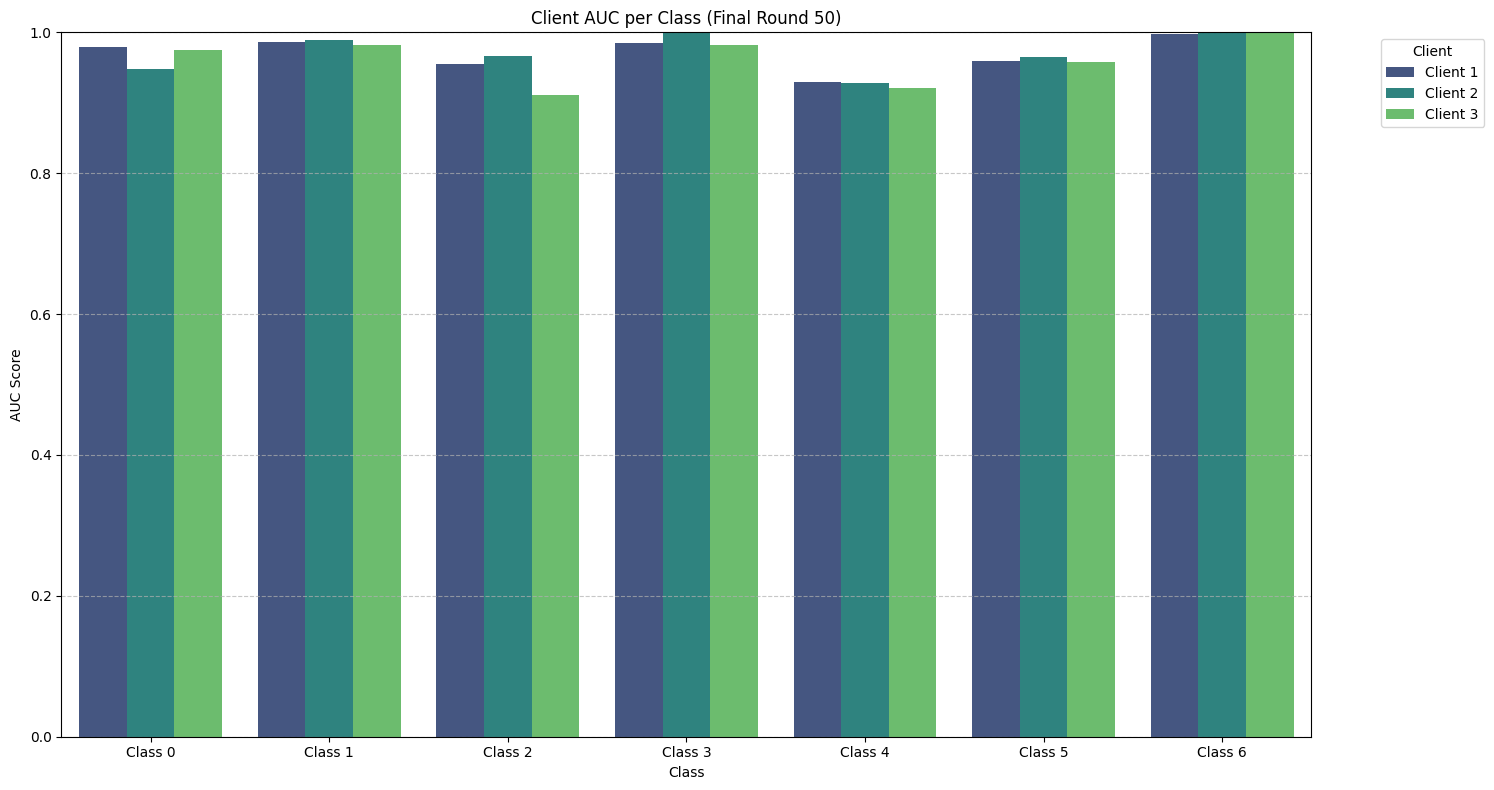

In [14]:
# --- Configuration ---
# Assuming you have a training_history.json file generated by your updated training script
filename = "training_history.json"

# --- IMPORTANT: Define your class names here if running this script standalone ---
# This list should match the order of your class IDs (0, 1, 2, ...)
# For example, if class 0 is 'Melanoma', class 1 is 'Nevus', etc.
# class_names = ['Melanoma', 'Nevus', 'Basal Cell Carcinoma', 'Actinic Keratosis', 'Benign Keratosis', 'Dermatofibroma', 'Vascular Lesion', 'Squamous Cell Carcinoma']
# If class_names is not defined here, it will be inferred as 'Class 0', 'Class 1', etc.
try:
    # Attempt to use class_names from the global scope if it's defined elsewhere in your full script
    _ = class_names
except NameError:
    # Fallback if class_names is not defined, will use generic labels
    class_names = [f'Class {i}' for i in range(num_classes)] # This will be updated after num_classes is determined


# --- Load the training history from the JSON file ---
try:
    with open(filename, 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    print(f"Error: {filename} not found. Please ensure the file exists and is in the correct directory.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Invalid JSON in {filename}. The file may be corrupted.")
    exit()

# --- Data Validation and Preprocessing ---
# Ensure history is a list and not empty
if not isinstance(history, list) or not history:
    print("Error: The loaded history is not in the expected list format or is empty.")
    if isinstance(history, dict): # Attempt to correct if it's a single dict (from older saving)
        print("Warning: Loaded history is a dictionary, converting to a list containing the dictionary.")
        history = [history]
    else:
        exit()

# Determine NUM_CLIENTS and num_classes from the loaded history
NUM_CLIENTS = 0
num_classes = 0
found_valid_data = False

for round_data in history:
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list) and round_data['client_histories']:
        NUM_CLIENTS = len(round_data['client_histories'])
        # Try to infer num_classes from 'class_aucs' or 'all_labels'
        for client_h in round_data['client_histories']:
            if 'class_aucs' in client_h and client_h['class_aucs']:
                # Assuming class_aucs keys are like 'class_0_auc', 'class_1_auc', etc.
                max_class_id = -1
                for key in client_h['class_aucs'].keys():
                    match = re.match(r'class_(\d+)_auc', key)
                    if match:
                        max_class_id = max(max_class_id, int(match.group(1)))
                if max_class_id != -1:
                    num_classes = max_class_id + 1
                    break # Found num_classes, exit inner loop
            elif 'all_labels' in client_h and client_h['all_labels']:
                unique_labels = np.unique(client_h['all_labels'])
                if len(unique_labels) > 0:
                    num_classes = max(unique_labels) + 1
                    break # Found num_classes, exit inner loop
        if num_classes > 0:
            found_valid_data = True
            break # Found client data and num_classes, exit outer loop

if not found_valid_data or NUM_CLIENTS == 0:
    print("Error: Could not determine the number of clients or classes from the loaded history.")
    print("Please ensure 'client_histories' and 'class_aucs'/'all_labels' are correctly saved in your JSON.")
    exit()

# If class_names was not defined globally, initialize it now based on inferred num_classes
try:
    _ = class_names
    if len(class_names) != num_classes: # If pre-defined, but length doesn't match
        print(f"Warning: Pre-defined class_names length ({len(class_names)}) does not match inferred num_classes ({num_classes}). Using generic class labels.")
        class_names = [f'Class {i}' for i in range(num_classes)]
except NameError:
    class_names = [f'Class {i}' for i in range(num_classes)]


# --- Prepare data structures for plotting ---
# For AUC comparison of each client (local model vs. global model)
client_avg_auc_per_round = defaultdict(list)  # Average AUC for each client's local model
global_avg_auc_per_round = defaultdict(list)  # Average AUC for global model on each client's test set

# For AUC of each class (global model, aggregated across clients)
class_auc_per_round_global_agg = defaultdict(list)

# --- Extract AUC data from history ---
for round_idx, round_data in enumerate(history):
    # Process client AUCs (Local Models)
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list):
        for client_id_idx in range(NUM_CLIENTS):
            if client_id_idx < len(round_data['client_histories']):
                client_data = round_data['client_histories'][client_id_idx]
                if 'class_aucs' in client_data and client_data['class_aucs']:
                    # Collect all class AUCs for this client in this round
                    current_client_class_aucs = [client_data['class_aucs'].get(f'class_{i}_auc', np.nan) for i in range(num_classes)]
                    client_avg_auc_per_round[client_id_idx].append(np.nanmean(current_client_class_aucs))
                else:
                    client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if class_aucs is missing
            else:
                client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if client data is missing

    # Process global model AUCs (on each client's test set)
    # We will collect all true_labels and all_probs from all clients' global_test_histories for this round
    round_global_all_labels = []
    round_global_all_probs = []
    
    if 'global_test_histories' in round_data and isinstance(round_data['global_test_histories'], list):
        for global_client_data in round_data['global_test_histories']:
            if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
                round_global_all_labels.extend(global_client_data['all_labels'])
                round_global_all_probs.extend(global_client_data['all_probs'])
        
        # Calculate overall global AUC for this round (aggregated across all clients' test sets)
        if round_global_all_labels and round_global_all_probs:
            true_labels_np = np.array(round_global_all_labels)
            pred_probs_np = np.array(round_global_all_probs)

            # Binarize true labels for multi-class AUC
            binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

            round_global_class_aucs_list = []
            for i in range(num_classes):
                try:
                    # Check if both positive and negative samples exist for the class
                    if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                        auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                        round_global_class_aucs_list.append(auc)
                    else:
                        round_global_class_aucs_list.append(np.nan)
                except ValueError:
                    round_global_class_aucs_list.append(np.nan)
            
            # Store the average AUC for the global model in this round
            # We use index 0 for global_avg_auc_per_round as it's a single global average
            global_avg_auc_per_round[0].append(np.nanmean(round_global_class_aucs_list))

            # Store AUC per class for the global model (aggregated)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(round_global_class_aucs_list[i])
        else: # If no data for global model in this round
            global_avg_auc_per_round[0].append(np.nan)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(np.nan)
    else: # If 'global_test_histories' key is missing or not a list
        global_avg_auc_per_round[0].append(np.nan)
        for i in range(num_classes):
            class_auc_per_round_global_agg[i].append(np.nan)


# --- Plotting Average AUC Comparison for Each Client (Local Model vs. Global Model) ---
plt.figure(figsize=(14, 7))
rounds_axis = range(1, len(history) + 1)

for client_id_idx in range(NUM_CLIENTS):
    # Plot local model AUC
    plt.plot(rounds_axis, client_avg_auc_per_round[client_id_idx],
             marker='o', linestyle='--', label=f'Client {client_id_idx + 1} (Local Model)')

# Plot global model AUC (only one line for the aggregated global model)
if global_avg_auc_per_round and global_avg_auc_per_round[0]:
    plt.plot(rounds_axis, global_avg_auc_per_round[0],
             marker='x', linestyle='-', linewidth=2, label='Global Model (Aggregated Test Sets)')

plt.title('Average AUC per Round: Local vs. Global Model for Each Client')
plt.xlabel('Round')
plt.ylabel('Average AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting AUC of Each Class (Global Model, aggregated across clients) ---
if class_auc_per_round_global_agg:
    plt.figure(figsize=(14, 7))
    for class_id, auc_values in class_auc_per_round_global_agg.items():
        plt.plot(rounds_axis, auc_values, marker='o', label=f'Class {class_id}')
    plt.title('AUC per Class for Global Model (Aggregated Test Sets)')
    plt.xlabel('Round')
    plt.ylabel('AUC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot AUC per class for the global model.")

# --- NEW PLOTS: Bar Graphs for Final Round AUCs ---

# 1. AUC against the class for the final round of the global model (inverted axes, different colors)
if history and 'global_test_histories' in history[-1] and history[-1]['global_test_histories']:
    final_round_global_aucs = {}
    # Aggregate class AUCs from all clients' global test histories in the final round
    final_global_all_labels = []
    final_global_all_probs = []
    for global_client_data in history[-1]['global_test_histories']:
        if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
            final_global_all_labels.extend(global_client_data['all_labels'])
            final_global_all_probs.extend(global_client_data['all_probs'])

    if final_global_all_labels and final_global_all_probs:
        true_labels_np = np.array(final_global_all_labels)
        pred_probs_np = np.array(final_global_all_probs)
        binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

        for i in range(num_classes):
            try:
                if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                    auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                    final_round_global_aucs[i] = auc # Store class ID as key
                else:
                    final_round_global_aucs[i] = np.nan
            except ValueError:
                final_round_global_aucs[i] = np.nan
    
    if final_round_global_aucs:
        # Sort by class ID to ensure correct order
        sorted_class_ids = sorted(final_round_global_aucs.keys())
        class_labels = [class_names[i] for i in sorted_class_ids] # Use actual class names
        auc_values = [final_round_global_aucs[i] for i in sorted_class_ids]
        
        # Generate a list of colors, one for each bar
        colors = plt.cm.viridis(np.linspace(0, 1, len(class_labels))) # Using 'viridis' colormap

        plt.figure(figsize=(12, 7))
        plt.barh(class_labels, auc_values, color=colors) # Use barh for horizontal bars
        plt.title(f'Global Model AUC per Class (Final Round {len(history)})')
        plt.xlabel('AUC Score') # X-axis is now AUC
        plt.ylabel('Class')     # Y-axis is now Class
        plt.xlim(0, 1) # AUC scores are between 0 and 1
        plt.grid(axis='x', linestyle='--', alpha=0.7) # Grid on x-axis
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Global Model per Class in the final round.")
else:
    print("No global test history found for the final round to plot AUC per class.")


# 2. AUC of each client for each class (for the final round)
if history and 'client_histories' in history[-1] and history[-1]['client_histories']:
    final_round_client_data = history[-1]['client_histories']
    
    # Prepare data for grouped bar chart
    client_class_aucs = defaultdict(list)
    client_ids = []
    
    for client_id_idx in range(NUM_CLIENTS):
        if client_id_idx < len(final_round_client_data):
            client_h = final_round_client_data[client_id_idx]
            client_ids.append(f'Client {client_h["client_id"]}')
            if 'class_aucs' in client_h and client_h['class_aucs']:
                for i in range(num_classes):
                    auc_val = client_h['class_aucs'].get(f'class_{i}_auc', np.nan)
                    client_class_aucs[i].append(auc_val)
            else:
                for i in range(num_classes):
                    client_class_aucs[i].append(np.nan) # Append NaN if class_aucs is missing

    if client_class_aucs:
        # Create a DataFrame for easier plotting with Seaborn (optional, but good for grouped bars)
        # If you strictly want only matplotlib, the logic would be more manual for bar positions
        
        # Convert defaultdict to a list of dictionaries for DataFrame creation
        plot_data = []
        for class_id, auc_values in client_class_aucs.items():
            for client_idx, auc in enumerate(auc_values):
                plot_data.append({'Client': client_ids[client_idx], 'Class': class_names[class_id], 'AUC': auc}) # Use actual class names
        
        df_client_aucs = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(15, 8))
        # Use Seaborn for grouped bar plot, as it handles grouping automatically
        sns.barplot(data=df_client_aucs, x='Class', y='AUC', hue='Client', palette='viridis')
        
        plt.title(f'Client AUC per Class (Final Round {len(history)})')
        plt.xlabel('Class')
        plt.ylabel('AUC Score')
        plt.ylim(0, 1)
        plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Clients per Class in the final round.")
else:
    print("No client history found for the final round to plot AUC per class.")

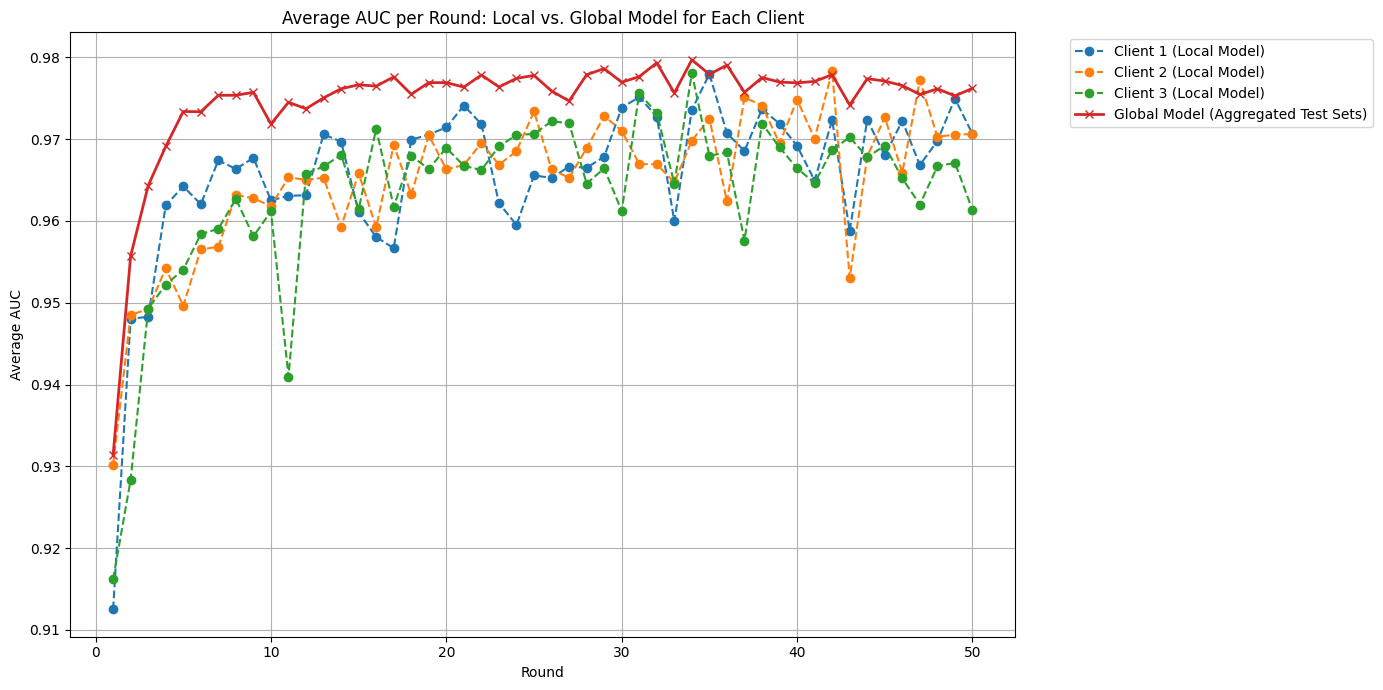

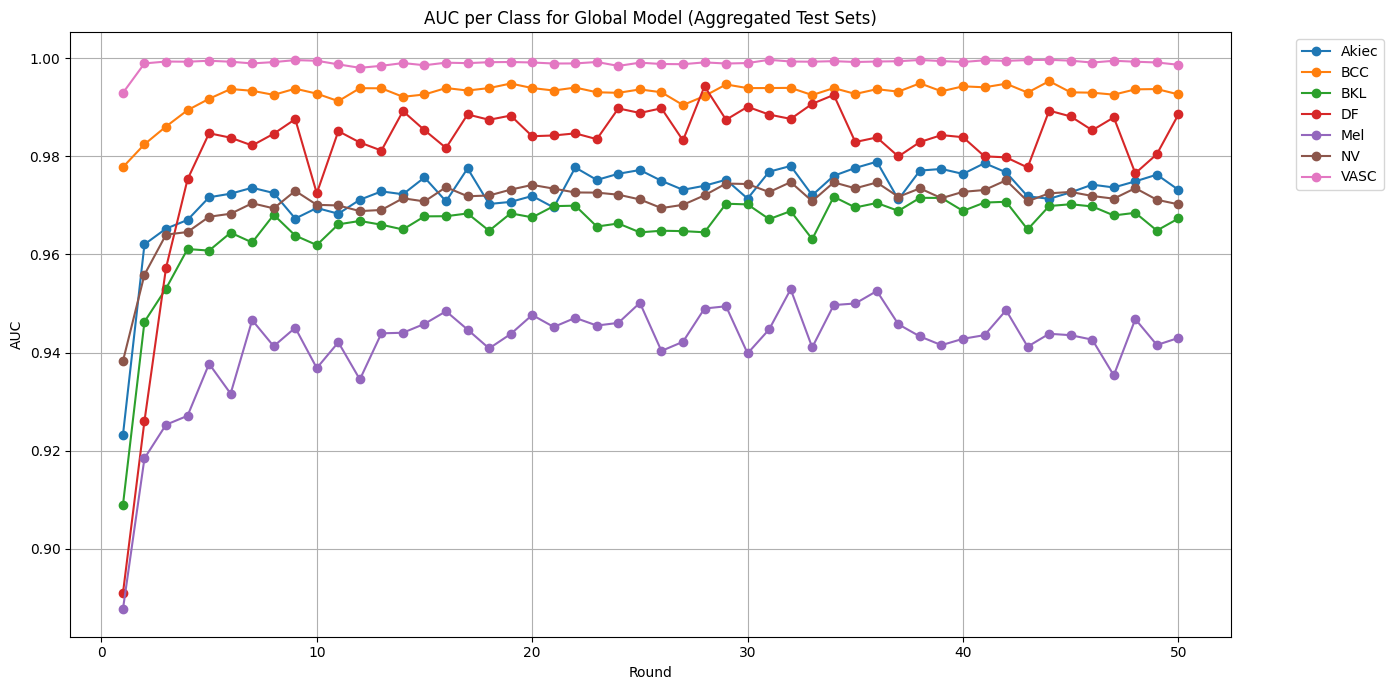

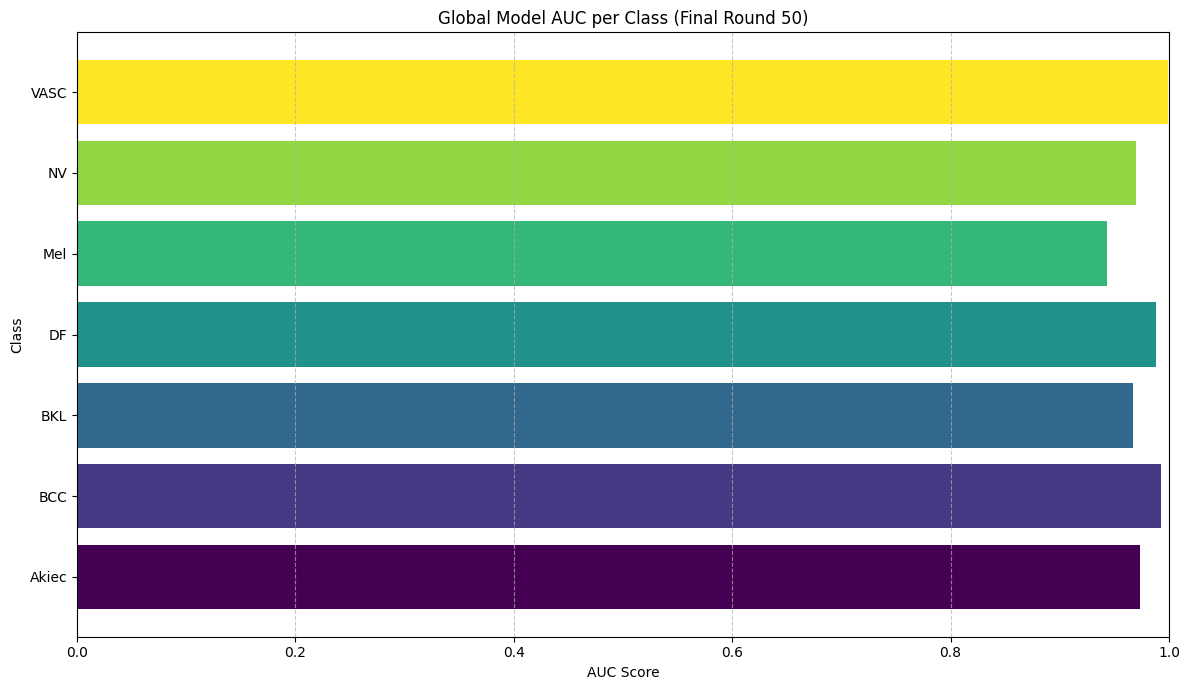

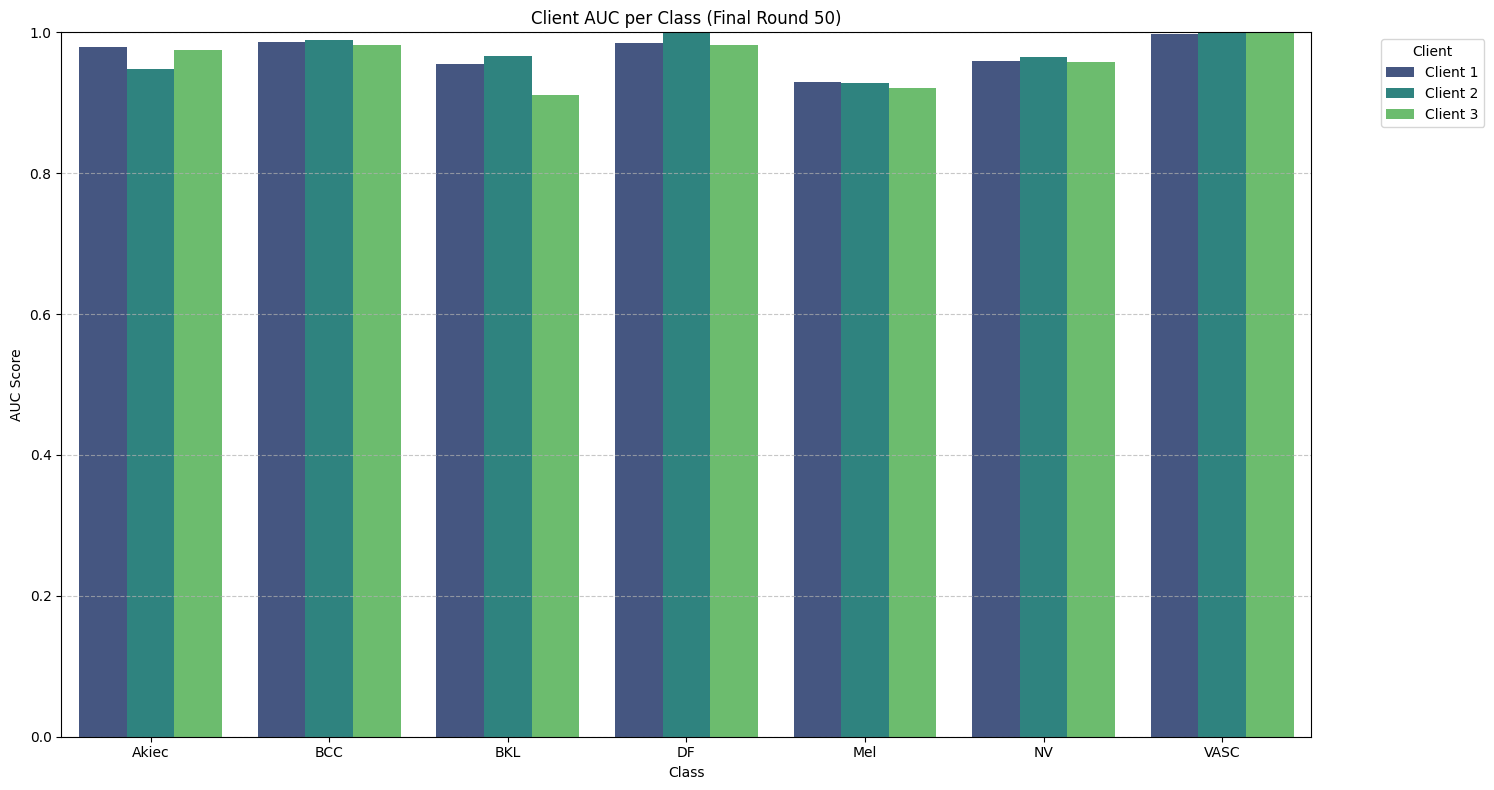

In [15]:
# --- Configuration ---
# Assuming you have a training_history.json file generated by your updated training script
filename = "training_history.json"

# --- IMPORTANT: Define your class names here if running this script standalone ---
# This list should match the order of your class IDs (0, 1, 2, ...)
# For example, if class 0 is 'Melanoma', class 1 is 'Nevus', etc.
class_names = ['Akiec', 'BCC', 'BKL', 'DF', 'Mel', 'NV', 'VASC'] # Updated class names
# If class_names is not defined here, it will be inferred as 'Class 0', 'Class 1', etc.
try:
    # Attempt to use class_names from the global scope if it's defined elsewhere in your full script
    _ = class_names
except NameError:
    # Fallback if class_names is not defined, will use generic labels
    class_names = [f'Class {i}' for i in range(num_classes)] # This will be updated after num_classes is determined


# --- Load the training history from the JSON file ---
try:
    with open(filename, 'r') as f:
        history = json.load(f)
except FileNotFoundError:
    print(f"Error: {filename} not found. Please ensure the file exists and is in the correct directory.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Invalid JSON in {filename}. The file may be corrupted.")
    exit()

# --- Data Validation and Preprocessing ---
# Ensure history is a list and not empty
if not isinstance(history, list) or not history:
    print("Error: The loaded history is not in the expected list format or is empty.")
    if isinstance(history, dict): # Attempt to correct if it's a single dict (from older saving)
        print("Warning: Loaded history is a dictionary, converting to a list containing the dictionary.")
        history = [history]
    else:
        exit()

# Determine NUM_CLIENTS and num_classes from the loaded history
NUM_CLIENTS = 0
num_classes = 0
found_valid_data = False

for round_data in history:
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list) and round_data['client_histories']:
        NUM_CLIENTS = len(round_data['client_histories'])
        # Try to infer num_classes from 'class_aucs' or 'all_labels'
        for client_h in round_data['client_histories']:
            if 'class_aucs' in client_h and client_h['class_aucs']:
                # Assuming class_aucs keys are like 'class_0_auc', 'class_1_auc', etc.
                max_class_id = -1
                for key in client_h['class_aucs'].keys():
                    match = re.match(r'class_(\d+)_auc', key)
                    if match:
                        max_class_id = max(max_class_id, int(match.group(1)))
                if max_class_id != -1:
                    num_classes = max_class_id + 1
                    break # Found num_classes, exit inner loop
            elif 'all_labels' in client_h and client_h['all_labels']:
                unique_labels = np.unique(client_h['all_labels'])
                if len(unique_labels) > 0:
                    num_classes = max(unique_labels) + 1
                    break # Found num_classes, exit inner loop
        if num_classes > 0:
            found_valid_data = True
            break # Found client data and num_classes, exit outer loop

if not found_valid_data or NUM_CLIENTS == 0:
    print("Error: Could not determine the number of clients or classes from the loaded history.")
    print("Please ensure 'client_histories' and 'class_aucs'/'all_labels' are correctly saved in your JSON.")
    exit()

# If class_names was not defined globally, initialize it now based on inferred num_classes
try:
    _ = class_names
    if len(class_names) != num_classes: # If pre-defined, but length doesn't match
        print(f"Warning: Pre-defined class_names length ({len(class_names)}) does not match inferred num_classes ({num_classes}). Using generic class labels.")
        class_names = [f'Class {i}' for i in range(num_classes)]
except NameError:
    class_names = [f'Class {i}' for i in range(num_classes)]


# --- Prepare data structures for plotting ---
# For AUC comparison of each client (local model vs. global model)
client_avg_auc_per_round = defaultdict(list)  # Average AUC for each client's local model
global_avg_auc_per_round = defaultdict(list)  # Average AUC for global model on each client's test set

# For AUC of each class (global model, aggregated across clients)
class_auc_per_round_global_agg = defaultdict(list)

# --- Extract AUC data from history ---
for round_idx, round_data in enumerate(history):
    # Process client AUCs (Local Models)
    if 'client_histories' in round_data and isinstance(round_data['client_histories'], list):
        for client_id_idx in range(NUM_CLIENTS):
            if client_id_idx < len(round_data['client_histories']):
                client_data = round_data['client_histories'][client_id_idx]
                if 'class_aucs' in client_data and client_data['class_aucs']:
                    # Collect all class AUCs for this client in this round
                    current_client_class_aucs = [client_data['class_aucs'].get(f'class_{i}_auc', np.nan) for i in range(num_classes)]
                    client_avg_auc_per_round[client_id_idx].append(np.nanmean(current_client_class_aucs))
                else:
                    client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if class_aucs is missing
            else:
                client_avg_auc_per_round[client_id_idx].append(np.nan) # Append NaN if client data is missing

    # Process global model AUCs (on each client's test set)
    # We will collect all true_labels and all_probs from all clients' global_test_histories for this round
    round_global_all_labels = []
    round_global_all_probs = []
    
    if 'global_test_histories' in round_data and isinstance(round_data['global_test_histories'], list):
        for global_client_data in round_data['global_test_histories']:
            if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
                round_global_all_labels.extend(global_client_data['all_labels'])
                round_global_all_probs.extend(global_client_data['all_probs'])
        
        # Calculate overall global AUC for this round (aggregated across all clients' test sets)
        if round_global_all_labels and round_global_all_probs:
            true_labels_np = np.array(round_global_all_labels)
            pred_probs_np = np.array(round_global_all_probs)

            # Binarize true labels for multi-class AUC
            binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

            round_global_class_aucs_list = []
            for i in range(num_classes):
                try:
                    # Check if both positive and negative samples exist for the class
                    if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                        auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                        round_global_class_aucs_list.append(auc)
                    else:
                        round_global_class_aucs_list.append(np.nan)
                except ValueError:
                    round_global_class_aucs_list.append(np.nan)
            
            # Store the average AUC for the global model in this round
            # We use index 0 for global_avg_auc_per_round as it's a single global average
            global_avg_auc_per_round[0].append(np.nanmean(round_global_class_aucs_list))

            # Store AUC per class for the global model (aggregated)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(round_global_class_aucs_list[i])
        else: # If no data for global model in this round
            global_avg_auc_per_round[0].append(np.nan)
            for i in range(num_classes):
                class_auc_per_round_global_agg[i].append(np.nan)
    else: # If 'global_test_histories' key is missing or not a list
        global_avg_auc_per_round[0].append(np.nan)
        for i in range(num_classes):
            class_auc_per_round_global_agg[i].append(np.nan)


# --- Plotting Average AUC Comparison for Each Client (Local Model vs. Global Model) ---
plt.figure(figsize=(14, 7))
rounds_axis = range(1, len(history) + 1)

for client_id_idx in range(NUM_CLIENTS):
    # Plot local model AUC
    plt.plot(rounds_axis, client_avg_auc_per_round[client_id_idx],
             marker='o', linestyle='--', label=f'Client {client_id_idx + 1} (Local Model)')

# Plot global model AUC (only one line for the aggregated global model)
if global_avg_auc_per_round and global_avg_auc_per_round[0]:
    plt.plot(rounds_axis, global_avg_auc_per_round[0],
             marker='x', linestyle='-', linewidth=2, label='Global Model (Aggregated Test Sets)')

plt.title('Average AUC per Round: Local vs. Global Model for Each Client')
plt.xlabel('Round')
plt.ylabel('Average AUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting AUC of Each Class (Global Model, aggregated across clients) ---
if class_auc_per_round_global_agg:
    plt.figure(figsize=(14, 7))
    for class_id, auc_values in class_auc_per_round_global_agg.items():
        plt.plot(rounds_axis, auc_values, marker='o', label=f'{class_names[class_id]}') # Use actual class names
    plt.title('AUC per Class for Global Model (Aggregated Test Sets)')
    plt.xlabel('Round')
    plt.ylabel('AUC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot AUC per class for the global model.")

# --- NEW PLOTS: Bar Graphs for Final Round AUCs ---

# 1. AUC against the class for the final round of the global model (inverted axes, different colors)
if history and 'global_test_histories' in history[-1] and history[-1]['global_test_histories']:
    final_round_global_aucs = {}
    # Aggregate class AUCs from all clients' global test histories in the final round
    final_global_all_labels = []
    final_global_all_probs = []
    for global_client_data in history[-1]['global_test_histories']:
        if 'all_labels' in global_client_data and 'all_probs' in global_client_data:
            final_global_all_labels.extend(global_client_data['all_labels'])
            final_global_all_probs.extend(global_client_data['all_probs'])

    if final_global_all_labels and final_global_all_probs:
        true_labels_np = np.array(final_global_all_labels)
        pred_probs_np = np.array(final_global_all_probs)
        binarized_labels = label_binarize(true_labels_np, classes=range(num_classes))

        for i in range(num_classes):
            try:
                if np.sum(binarized_labels[:, i]) > 0 and np.sum(binarized_labels[:, i] == 0) > 0:
                    auc = roc_auc_score(binarized_labels[:, i], pred_probs_np[:, i])
                    final_round_global_aucs[i] = auc # Store class ID as key
                else:
                    final_round_global_aucs[i] = np.nan
            except ValueError:
                final_round_global_aucs[i] = np.nan
    
    if final_round_global_aucs:
        # Sort by class ID to ensure correct order
        sorted_class_ids = sorted(final_round_global_aucs.keys())
        class_labels = [class_names[i] for i in sorted_class_ids] # Use actual class names
        auc_values = [final_round_global_aucs[i] for i in sorted_class_ids]
        
        # Generate a list of colors, one for each bar
        colors = plt.cm.viridis(np.linspace(0, 1, len(class_labels))) # Using 'viridis' colormap

        plt.figure(figsize=(12, 7))
        plt.barh(class_labels, auc_values, color=colors) # Use barh for horizontal bars
        plt.title(f'Global Model AUC per Class (Final Round {len(history)})')
        plt.xlabel('AUC Score') # X-axis is now AUC
        plt.ylabel('Class')     # Y-axis is now Class
        plt.xlim(0, 1) # AUC scores are between 0 and 1
        plt.grid(axis='x', linestyle='--', alpha=0.7) # Grid on x-axis
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Global Model per Class in the final round.")
else:
    print("No global test history found for the final round to plot AUC per class.")


# 2. AUC of each client for each class (for the final round)
if history and 'client_histories' in history[-1] and history[-1]['client_histories']:
    final_round_client_data = history[-1]['client_histories']
    
    # Prepare data for grouped bar chart
    client_class_aucs = defaultdict(list)
    client_ids = []
    
    for client_id_idx in range(NUM_CLIENTS):
        if client_id_idx < len(final_round_client_data):
            client_h = final_round_client_data[client_id_idx]
            client_ids.append(f'Client {client_h["client_id"]}')
            if 'class_aucs' in client_h and client_h['class_aucs']:
                for i in range(num_classes):
                    auc_val = client_h['class_aucs'].get(f'class_{i}_auc', np.nan)
                    client_class_aucs[i].append(auc_val)
            else:
                for i in range(num_classes):
                    client_class_aucs[i].append(np.nan) # Append NaN if class_aucs is missing

    if client_class_aucs:
        # Create a DataFrame for easier plotting with Seaborn (optional, but good for grouped bars)
        # If you strictly want only matplotlib, the logic would be more manual for bar positions
        
        # Convert defaultdict to a list of dictionaries for DataFrame creation
        plot_data = []
        for class_id, auc_values in client_class_aucs.items():
            for client_idx, auc in enumerate(auc_values):
                plot_data.append({'Client': client_ids[client_idx], 'Class': class_names[class_id], 'AUC': auc}) # Use actual class names
        
        df_client_aucs = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(15, 8))
        # Use Seaborn for grouped bar plot, as it handles grouping automatically
        sns.barplot(data=df_client_aucs, x='Class', y='AUC', hue='Client', palette='viridis')
        
        plt.title(f'Client AUC per Class (Final Round {len(history)})')
        plt.xlabel('Class')
        plt.ylabel('AUC Score')
        plt.ylim(0, 1)
        plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data for Clients per Class in the final round.")
else:
    print("No client history found for the final round to plot AUC per class.")
